## Project Template

In [2]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

from pyspark.context import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars.packages", 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0') \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4793de89-4ca8-45b3-a987-150761bdc39d;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.0.0 in central
	found org.apache.kafka#kafka-clients;2.4.1 in central
	found com.github.luben#zstd-jni;1.4.4-3 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.7.5 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 1744ms :: artifacts dl 2

Be sure to start the stream on Kafka!

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType, TimestampType, DateType

schema = StructType(
      [
        StructField("name", StringType(), False),
        StructField("price", DoubleType(), False),
        StructField("timestamp", TimestampType(), False),
      ]
    )

In [4]:
kafka_server = "kafka1:9092"   
from pyspark.sql.functions import from_json

lines = (spark.readStream                        # Get the DataStreamReader
  .format("kafka")                                 # Specify the source format as "kafka"
  .option("kafka.bootstrap.servers", kafka_server) # Configure the Kafka server name and port
  .option("subscribe", "stock")                       # Subscribe to the "en" Kafka topic 
  .option("startingOffsets", "earliest")           # The start point when a query is started
  .option("maxOffsetsPerTrigger", 100)             # Rate limit on max offsets per trigger interval
  .load()
  .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))
# Load the DataFrame
)
df = lines.select("parsed_value.*")


## The assignment starts here



## Select the N most valuable stocks in a window (TASK 1)

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install dataframe-image

In [4]:
import time
from pyspark.sql.streaming import StreamingQueryException
# Visualization code
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, col
from pyspark.sql import functions as F

In [6]:
# Group the data by a 20-minute window and stock name, and calculate the average price
windowedDF = df.groupBy(
    window(col("timestamp"), "5 minutes"),
    "name"
).avg("price").withColumnRenamed("avg(price)", "avg_price")

# Now, since you want the 5 most valuable stocks, we will have to do a ranking
# For streaming DataFrame, we would need to write the results in update mode to a query sink that supports updates (like a memory sink or a Delta table)

# We need to define an aggregation query
topStocksQuery = windowedDF \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .foreachBatch(lambda df, epoch_id: df.orderBy(F.desc("avg_price")).limit(10).show(truncate=False)) \
    .start()

topStocksQuery.awaitTermination(timeout=5)
topStocksQuery.stop()


24/12/04 19:31:13 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-eaacd8c8-2715-4f83-9f7c-8d502e6c5183. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


+------------------------------------------+----+---------+
|window                                    |name|avg_price|
+------------------------------------------+----+---------+
|[2024-12-02 15:25:00, 2024-12-02 15:30:00]|AZO |384.01   |
|[2024-12-02 15:25:00, 2024-12-02 15:30:00]|ISRG|192.6465 |
|[2024-12-02 15:30:00, 2024-12-02 15:35:00]|RE  |128.37   |
|[2024-12-02 15:30:00, 2024-12-02 15:35:00]|PXD |126.345  |
|[2024-12-02 15:25:00, 2024-12-02 15:30:00]|CMI |119.79   |
|[2024-12-02 15:25:00, 2024-12-02 15:30:00]|KMB |90.08    |
|[2024-12-02 15:25:00, 2024-12-02 15:30:00]|LH  |90.065   |
|[2024-12-02 15:30:00, 2024-12-02 15:35:00]|ACN |77.0     |
|[2024-12-02 15:30:00, 2024-12-02 15:35:00]|VTR |72.1     |
|[2024-12-02 15:30:00, 2024-12-02 15:35:00]|ARE |71.155   |
+------------------------------------------+----+---------+



24/12/04 19:31:53 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-b3af5190-9330-42ed-b873-3c7965eb90a0. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


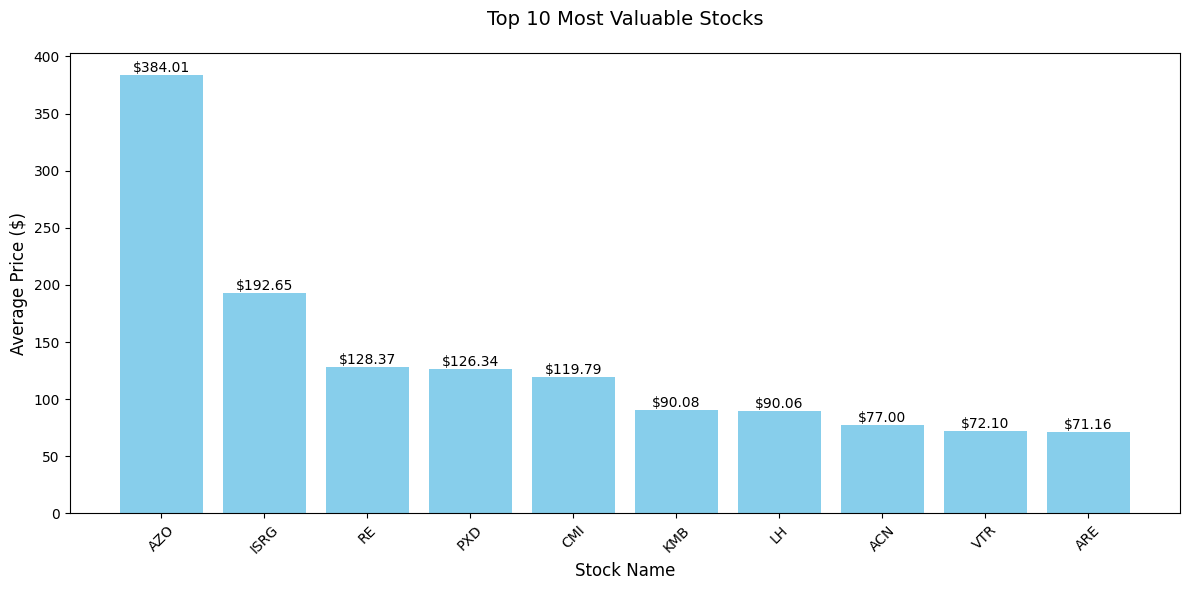

In [7]:
# Step 2: Define the streaming query to process top 10 stocks by average price
def process_batch(batch_df, epoch_id):
    # Order by avg_price and limit to top 10
    pandas_df = batch_df.orderBy(F.desc("avg_price")).limit(10).toPandas()

    # Step 3: Create a plot from the Pandas DataFrame
    if not pandas_df.empty:
        # Extract data for plotting
        names = pandas_df["name"]
        avg_prices = pandas_df["avg_price"]

        # Create visualization
        plt.figure(figsize=(12, 6))
        bars = plt.bar(names, avg_prices, color="skyblue")
        plt.title("Top 10 Most Valuable Stocks", fontsize=14, pad=20)
        plt.xlabel("Stock Name", fontsize=12)
        plt.ylabel("Average Price ($)", fontsize=12)
        plt.xticks(rotation=45)

        # Add value labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"${height:.2f}",
                ha="center",
                va="bottom",
            )

        plt.tight_layout()
        plt.show()
    else:
        print("No data available for visualization.")

# Step 4: Write the streaming query
topStocksQuery = windowedDF.writeStream \
    .outputMode("complete") \
    .format("console") \
    .foreachBatch(process_batch) \
    .start()

# Step 5: Await termination (adjust timeout as needed)
topStocksQuery.awaitTermination(timeout=10)
topStocksQuery.stop()


## Select the stocks that lost value between two windows (TASK 2)

In [26]:
df.printSchema()


root
 |-- name: string (nullable = true)
 |-- avg_price: long (nullable = true)
 |-- normalized_avg_price: double (nullable = true)



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, col, last
from pyspark.sql.types import StringType, DoubleType, StructType, StructField, TimestampType


# Use a dictionary to hold the state of each stock
stock_states = {}
# Set to hold names of stocks that lost value
stocks_that_lost_value = set()

# Define a class to hold the state of each stock
class StockState:
    def __init__(self, name):
        self.name = name
        self.last_price = None
        self.last_window_end = None
        self.lost_value = False  # Add flag to track if the stock lost value

    def update(self, price, window_end):
        if self.last_window_end is None or window_end > self.last_window_end:
            if self.last_price is not None and price < self.last_price:
                self.lost_value = True # Stock lost value
                stocks_that_lost_value.add(self.name)
            else:
                self.lost_value = False  # Stock did not lose value
            self.last_price = price
            self.last_window_end = window_end
        # Return the state including whether the stock lost value
        return (self.name, self.last_price, self.last_window_end, self.lost_value)


# Define the watermark and window operation on the streaming DataFrame
windowedDF = df \
    .withWatermark("timestamp", "5 minutes") \
    .groupBy(
        col("name"),
        window(col("timestamp"), "10 minutes")
    ) \
    .agg(
        last("price").alias("last_price")
    )

def process_batch(df, epoch_id):
    # Process the DataFrame row by row
    for row in df.collect():
        stock_name = row['name']
        price = row['last_price']
        window_end = row['window'].end

        # Get the stock state or create it if it doesn't exist
        stock_state = stock_states.get(stock_name, StockState(stock_name))
        
        # Update the state and check if the stock lost value
        result = stock_state.update(price, window_end)
        stock_states[stock_name] = stock_state  # Update the state in the dictionary

    print(stocks_that_lost_value)

# Define the streaming query using the process_batch function
query = windowedDF.writeStream \
    .outputMode("update") \
    .foreachBatch(process_batch) \
    .start()  # Start the streaming query

# Await termination of the streaming query (this is running continuously)
query.awaitTermination(timeout=60)
query.stop()


{'ISRG', 'AKAM', 'DFS', 'XYL'}


2024-12-04 19:49:41,879 - INFO - Received command c on object id p13


{'ISRG', 'AKAM', 'DFS', 'XYL'}


2024-12-04 19:49:48,680 - INFO - Received command c on object id p13
2024-12-04 19:49:51,678 - INFO - Received command  on object id  (69 + 8) / 200]
2024-12-04 19:49:51,686 - INFO - Closing down callback connection


{'AKAM', 'SPG', 'C', 'FRT', 'ESRX', 'HCN', 'GLW', 'MAA', 'ISRG', 'ES', 'XOM', 'CCL', 'KMI', 'CAG', 'TGT', 'UTX', 'XYL', 'BF.B', 'DFS', 'T', 'PEP', 'MAC', 'SCG', 'JNPR'}


2024-12-04 19:49:55,221 - INFO - Received command c on object id p13


{'AKAM', 'AET', 'UDR', 'RL', 'SPG', 'BXP', 'PNW', 'C', 'MON', 'FRT', 'ESRX', 'HCN', 'GIS', 'AIV', 'GLW', 'RRC', 'MAA', 'TIF', 'ISRG', 'ES', 'XOM', 'CCL', 'KMI', 'CAG', 'TGT', 'UTX', 'XYL', 'ACN', 'ORCL', 'BF.B', 'DFS', 'T', 'PEP', 'MAC', 'HD', 'SCG', 'JNPR'}


2024-12-04 19:50:00,225 - INFO - Received command c on object id p13


{'AKAM', 'IRM', 'AET', 'UDR', 'RL', 'SPG', 'BXP', 'EXPD', 'PNW', 'C', 'MCD', 'DLR', 'MON', 'FRT', 'ESRX', 'HCN', 'GIS', 'AIV', 'GLW', 'RRC', 'ED', 'MAA', 'TIF', 'ISRG', 'ES', 'FOXA', 'VTR', 'VIAB', 'XOM', 'CCL', 'KMI', 'CAG', 'TGT', 'UTX', 'IBM', 'HSY', 'NEM', 'WMB', 'IR', 'XYL', 'ACN', 'LH', 'ORCL', 'BF.B', 'DFS', 'T', 'XEL', 'PEP', 'MAC', 'SNPS', 'HD', 'SCG', 'JNPR'}


2024-12-04 19:50:05,892 - INFO - Received command c on object id p13


{'AKAM', 'IRM', 'AET', 'UDR', 'RL', 'SPG', 'AEP', 'BXP', 'EXPD', 'PNW', 'C', 'MCD', 'DLR', 'CMS', 'MON', 'FRT', 'ESRX', 'ETR', 'HCN', 'GIS', 'AIV', 'GLW', 'RRC', 'ED', 'MAA', 'TIF', 'ISRG', 'ES', 'FOXA', 'VTR', 'VIAB', 'EW', 'HUM', 'XOM', 'CCL', 'KMI', 'CAG', 'TGT', 'UTX', 'IBM', 'HSY', 'NEM', 'WMB', 'IR', 'NTAP', 'CHRW', 'XYL', 'ACN', 'LH', 'ORCL', 'BF.B', 'DFS', 'T', 'XEL', 'PEP', 'WAT', 'MAC', 'SNPS', 'DHI', 'HD', 'SCG', 'JNPR'}


2024-12-04 19:50:12,095 - INFO - Received command c on object id p13


{'ARE', 'AKAM', 'IRM', 'MRO', 'AET', 'KSU', 'UDR', 'RL', 'SPG', 'AEP', 'BXP', 'EXPD', 'PNW', 'C', 'MCD', 'DLR', 'CHK', 'CMS', 'MON', 'FRT', 'ESRX', 'O', 'ETR', 'HCN', 'GIS', 'AIV', 'GLW', 'RRC', 'ED', 'MAA', 'TIF', 'ISRG', 'ES', 'FOXA', 'VTR', 'VIAB', 'EW', 'HUM', 'XOM', 'CCL', 'KMI', 'CAG', 'TGT', 'UTX', 'IBM', 'HSY', 'NEM', 'WMB', 'IR', 'NTAP', 'CHRW', 'XYL', 'ACN', 'LH', 'ORCL', 'BF.B', 'SO', 'DFS', 'T', 'XEL', 'PEP', 'WAT', 'MAC', 'SNPS', 'DHI', 'HD', 'SCG', 'JNPR'}


2024-12-04 19:50:18,028 - INFO - Received command c on object id p13


Creating streaming query...
Starting streaming query...


24/12/04 19:34:29 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-1c7a3305-12fa-4270-a50e-8adff4c07294. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


Analysis Results:

Top 10 Stocks with Biggest Value Loss:
Stock  Start Price($) End Price($) Change($)  Change(%) 
----------------------------------------------------------------------
GPC    $78.22       $74.82       $-3.40     -4.35    %
GPC    $78.22       $74.82       $-3.40     -4.35    %
GPC    $78.22       $74.82       $-3.40     -4.35    %
WMB    $36.93       $33.66       $-3.27     -8.85    %
WMB    $36.93       $33.66       $-3.27     -8.85    %
ZBH    $81.19       $78.77       $-2.42     -2.97    %
ZBH    $81.19       $78.77       $-2.42     -2.97    %
ORLY   $112.17      $110.26      $-1.91     -1.70    %
ORLY   $112.17      $110.26      $-1.91     -1.70    %
SO     $46.36       $44.59       $-1.77     -3.82    %


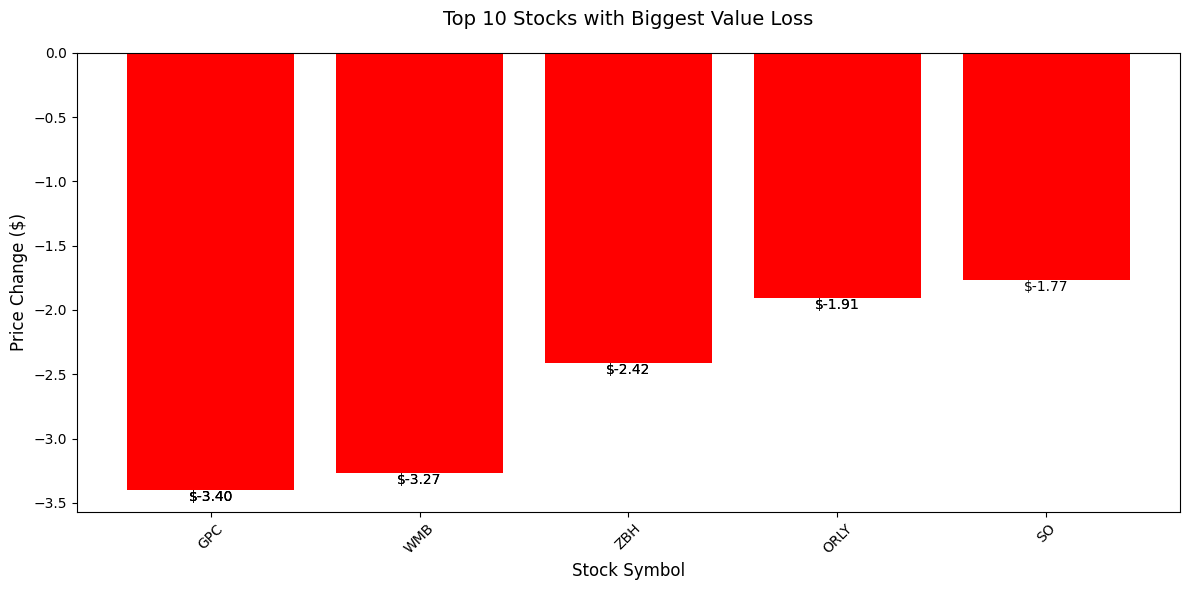


Stopping query...


Query execution completed.


In [10]:

# Define window parameters
window_duration = "1 minute"
watermark_delay = "2 minutes"

# Create streaming query for stocks losing value
print("Creating streaming query...")
losing_stocks_stream = (df
    .withWatermark("timestamp", watermark_delay)
    .groupBy(
        window(col("timestamp"), window_duration),
        col("name")
    )
    .agg(
        first("price").alias("start_price"),
        last("price").alias("end_price")
    )
    .withColumn("price_change", col("end_price") - col("start_price"))
    .filter(col("price_change") < 0)  # Only keep stocks that lost value
    .orderBy(col("price_change"))  # Order by biggest losses first
)

# Create a list to store the results
collected_data = []

def process_batch(df, epoch_id):
    # Collect data from the current batch
    batch_data = df.collect()
    collected_data.extend(batch_data)

print("Starting streaming query...")
query = (losing_stocks_stream
    .writeStream
    .outputMode("complete")
    .format("console")
    .foreachBatch(process_batch)
    .option("truncate", "false")
    .start()
)

print("Collecting data for 60 seconds...")
time.sleep(60)  # Wait for data collection

print("Analysis Results:")
try:
    if collected_data:
        # Get top 10 biggest losses
        top_10_losses = sorted(collected_data, key=lambda x: x['price_change'])[:10]
        
        # Display table of top 10 losing stocks
        print("\nTop 10 Stocks with Biggest Value Loss:")
        print("=" * 70)
        print(f"{'Stock':<6} {'Start Price($)':<12} {'End Price($)':<12} {'Change($)':<10} {'Change(%)':<10}")
        print("-" * 70)
        for stock in top_10_losses:
            percent_change = (stock['price_change'] / stock['start_price']) * 100
            print(f"{stock['name']:<6} ${stock['start_price']:<11.2f} ${stock['end_price']:<11.2f} ${stock['price_change']:<9.2f} {percent_change:<9.2f}%")
        print("=" * 70)
        
        # Create visualization
        names = [stock['name'] for stock in top_10_losses]
        changes = [stock['price_change'] for stock in top_10_losses]
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(names, changes, color='red')
        plt.title('Top 10 Stocks with Biggest Value Loss', fontsize=14, pad=20)
        plt.xlabel('Stock Symbol', fontsize=12)
        plt.ylabel('Price Change ($)', fontsize=12)
        plt.xticks(rotation=45)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height,
                     f'${height:.2f}',
                     ha='center', va='bottom' if height >= 0 else 'top')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No data collected for visualization")

except Exception as e:
    print(f"Error creating visualization: {e}")

finally:
    print("\nStopping query...")
    query.awaitTermination(30)  # Allow some extra time for any final processing
    query.stop()
    print("Query execution completed.")


## Select the stock that gained the most (between windows) 

## TASK 3

24/12/04 19:42:39 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-289b3ff2-1ccd-45fb-915f-27a43091bcf6. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
2024-12-04 19:42:40,155 - INFO - Streaming query started. Collecting data...
2024-12-04 19:42:40,928 - INFO - Callback Connection ready to receive messages
2024-12-04 19:42:40,943 - INFO - Received command c on object id p9
2024-12-04 19:42:46,272 - INFO - Top Gainers: [('AIZ', 0.6299999999999955)]     


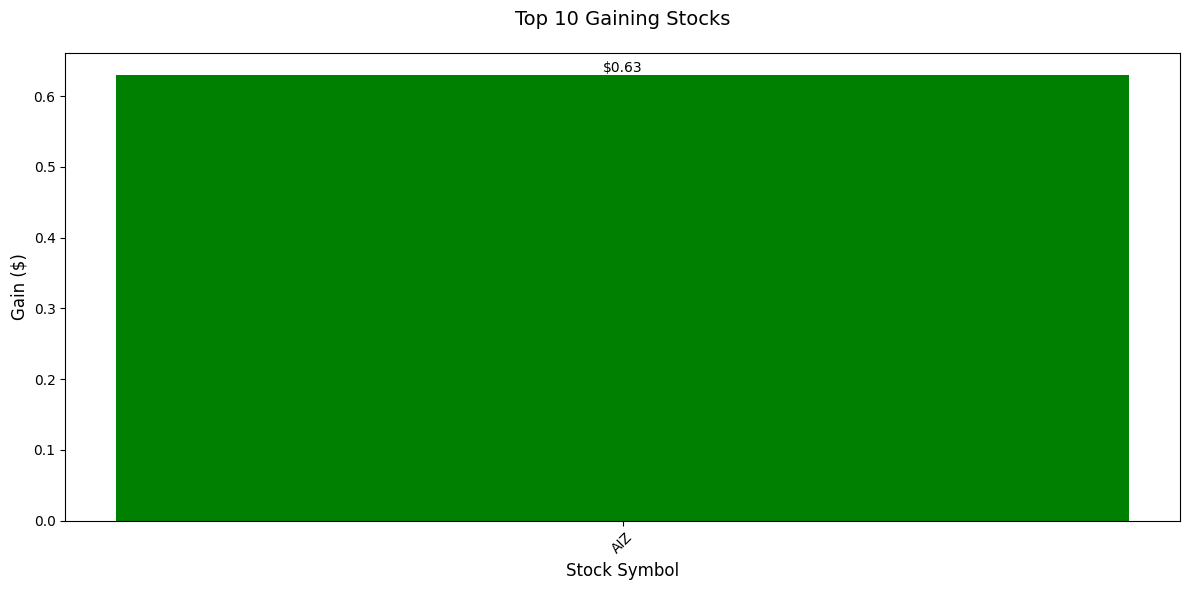

2024-12-04 19:42:47,062 - INFO - Received command c on object id p9
2024-12-04 19:42:51,391 - INFO - Top Gainers: [('ADBE', 6.020000000000003), ('TGT', 5.619999999999997), ('YUM', 5.364000000000004), ('AIZ', 0.6299999999999955)]


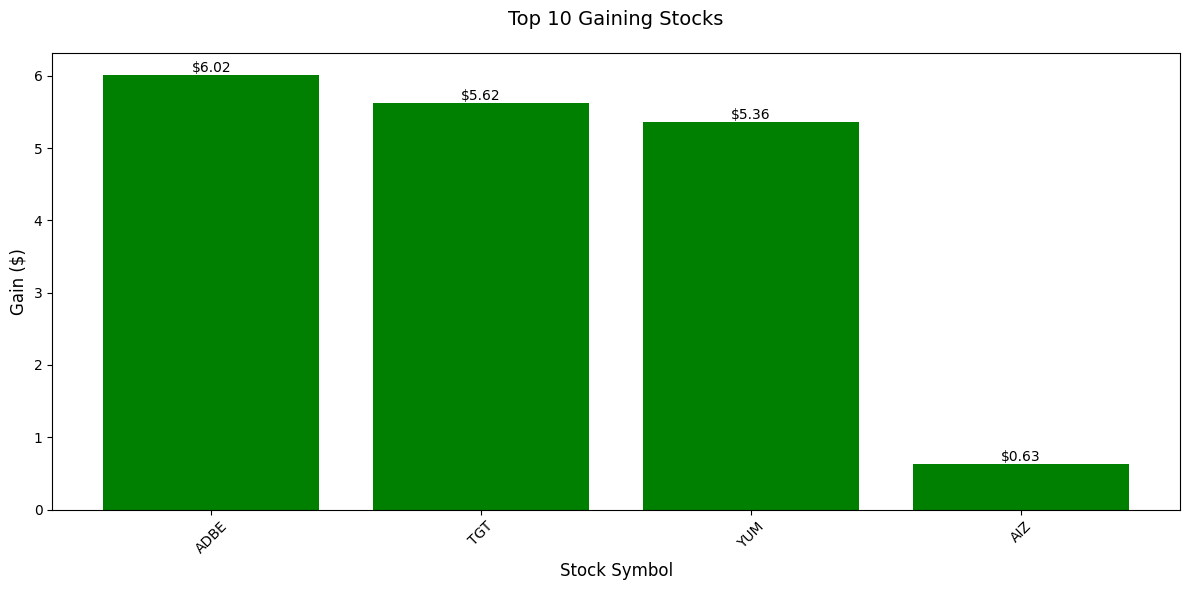

2024-12-04 19:42:52,094 - INFO - Received command c on object id p9
2024-12-04 19:42:56,573 - INFO - Top Gainers: [('VRTX', 30.93), ('KMB', 14.840000000000003), ('HCP', 6.630000000000003), ('CL', 6.325000000000003), ('ADBE', 6.020000000000003), ('TGT', 5.619999999999997), ('YUM', 5.364000000000004), ('PFE', 3.3500000000000014), ('AIZ', 0.6299999999999955)]


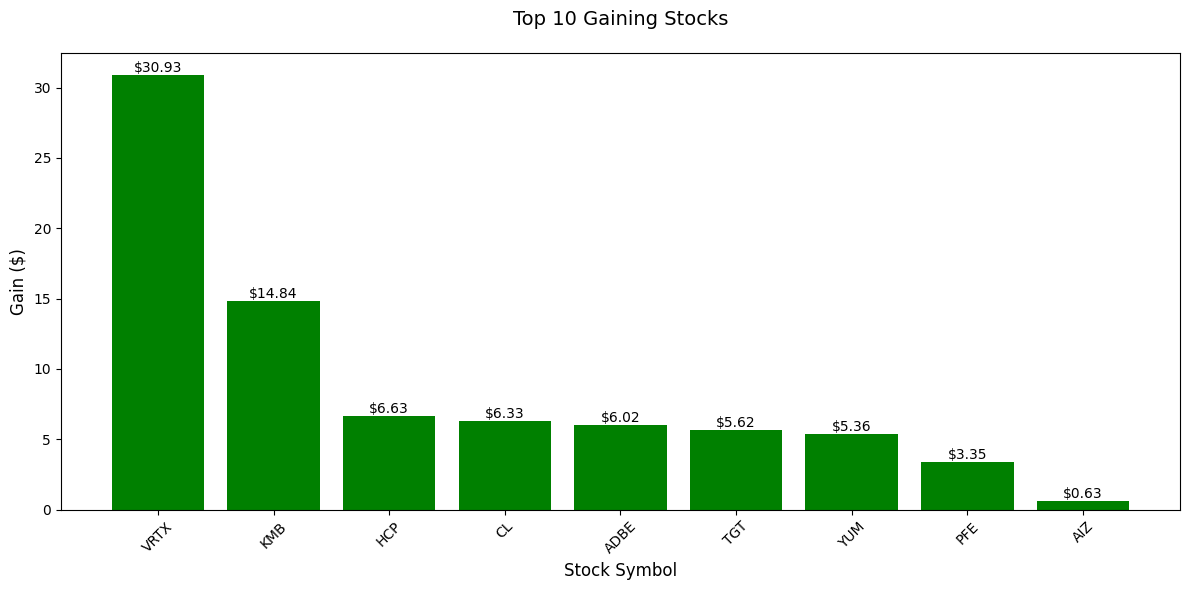

2024-12-04 19:42:57,535 - INFO - Received command c on object id p9
2024-12-04 19:43:02,154 - INFO - Top Gainers: [('VRTX', 30.93), ('KMB', 14.840000000000003), ('IT', 8.93), ('PKG', 8.149999999999999), ('HCP', 6.630000000000003), ('CL', 6.325000000000003), ('ADBE', 6.020000000000003), ('TGT', 5.619999999999997), ('YUM', 5.364000000000004), ('ZION', 4.030000000000001)]


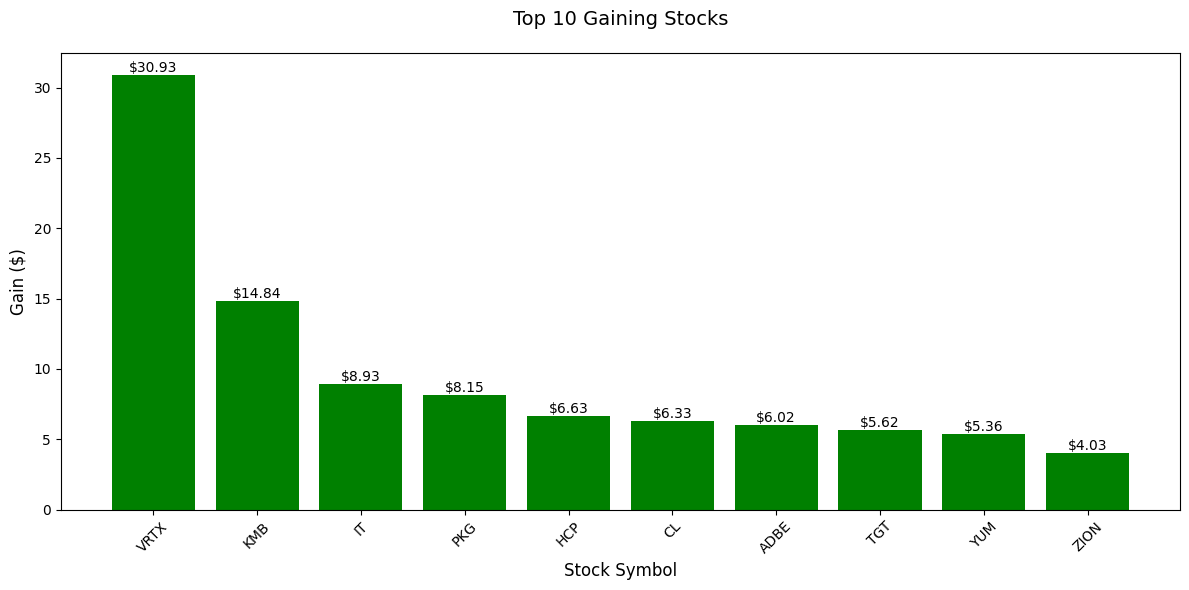

2024-12-04 19:43:03,059 - INFO - Received command c on object id p9
2024-12-04 19:43:07,890 - INFO - Top Gainers: [('VRTX', 30.93), ('KMB', 14.840000000000003), ('IT', 8.93), ('PKG', 8.149999999999999), ('HCP', 6.630000000000003), ('CL', 6.325000000000003), ('ADBE', 6.020000000000003), ('TGT', 5.619999999999997), ('YUM', 5.364000000000004), ('ZION', 4.030000000000001)]


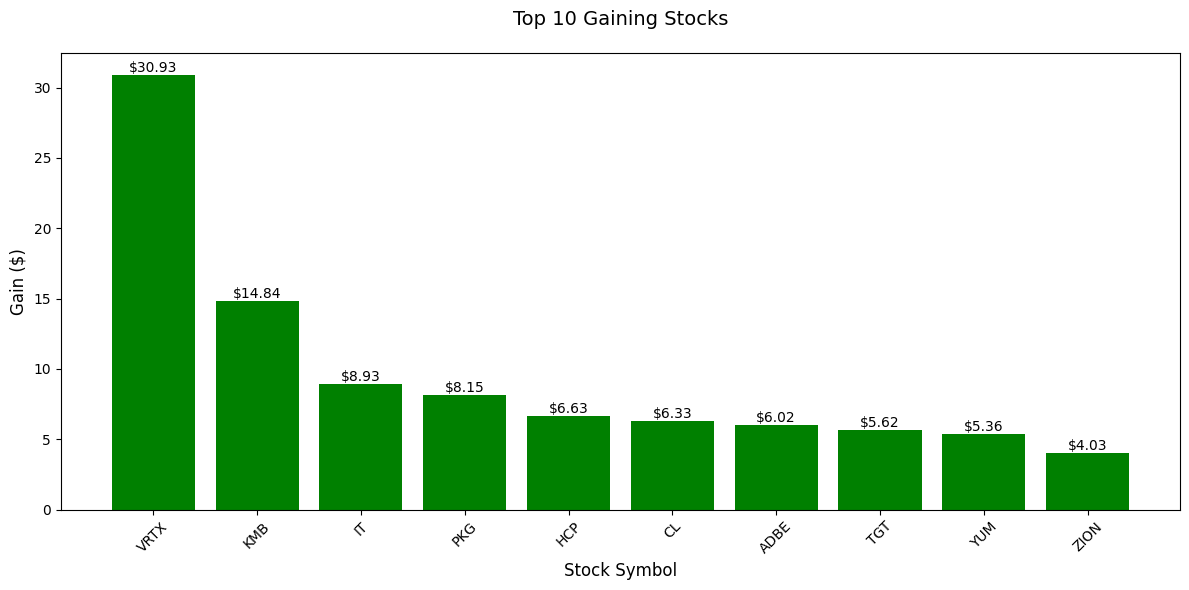

2024-12-04 19:43:09,558 - INFO - Received command c on object id p9
2024-12-04 19:43:15,636 - INFO - Top Gainers: [('VRTX', 30.93), ('KMB', 14.840000000000003), ('IT', 8.93), ('PKG', 8.149999999999999), ('HCP', 6.630000000000003), ('CL', 6.325000000000003), ('ADBE', 6.020000000000003), ('TGT', 5.619999999999997), ('PNW', 5.419999999999995), ('YUM', 5.364000000000004)]


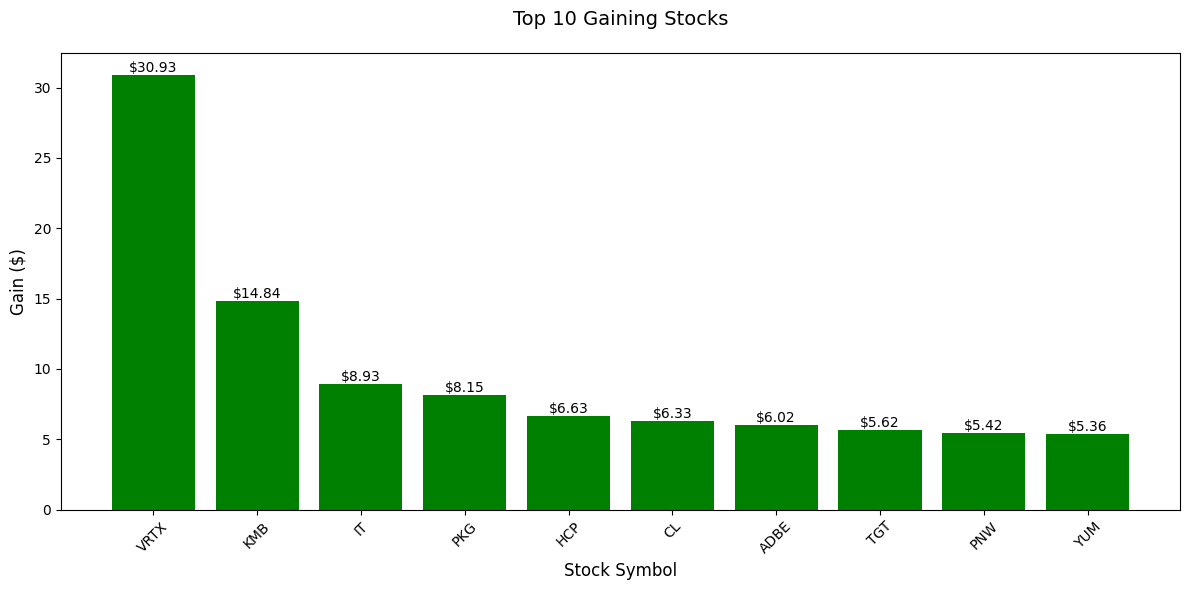

2024-12-04 19:43:16,858 - INFO - Received command c on object id p9
2024-12-04 19:43:22,069 - INFO - Top Gainers: [('VRTX', 30.93), ('KMB', 14.840000000000003), ('CMI', 12.549999999999997), ('KORS', 10.909999999999997), ('IT', 8.93), ('LH', 8.695000000000007), ('PKG', 8.149999999999999), ('HCP', 6.630000000000003), ('CL', 6.325000000000003), ('ADBE', 6.020000000000003)]


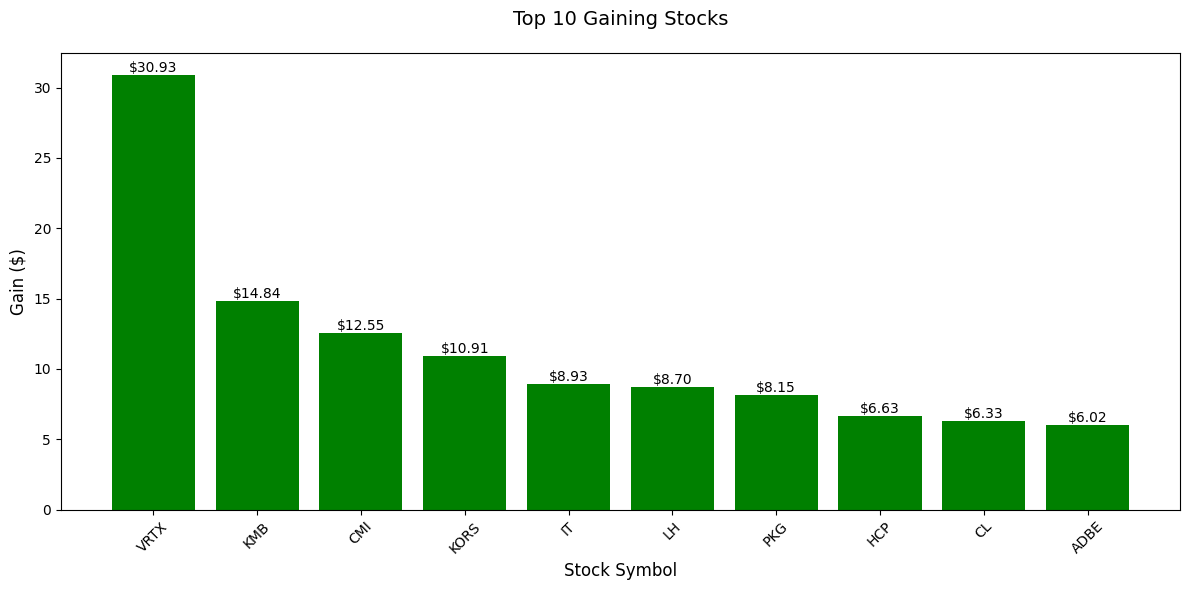

2024-12-04 19:43:24,888 - INFO - Received command c on object id p9
2024-12-04 19:43:30,857 - INFO - Top Gainers: [('VRTX', 30.93), ('MCO', 22.32), ('EOG', 21.64), ('AYI', 20.83999999999999), ('UHS', 19.68), ('DOV', 17.5), ('ORLY', 17.070000000000007), ('ECL', 14.909999999999997), ('KMB', 14.840000000000003), ('SLB', 13.054999999999993)]


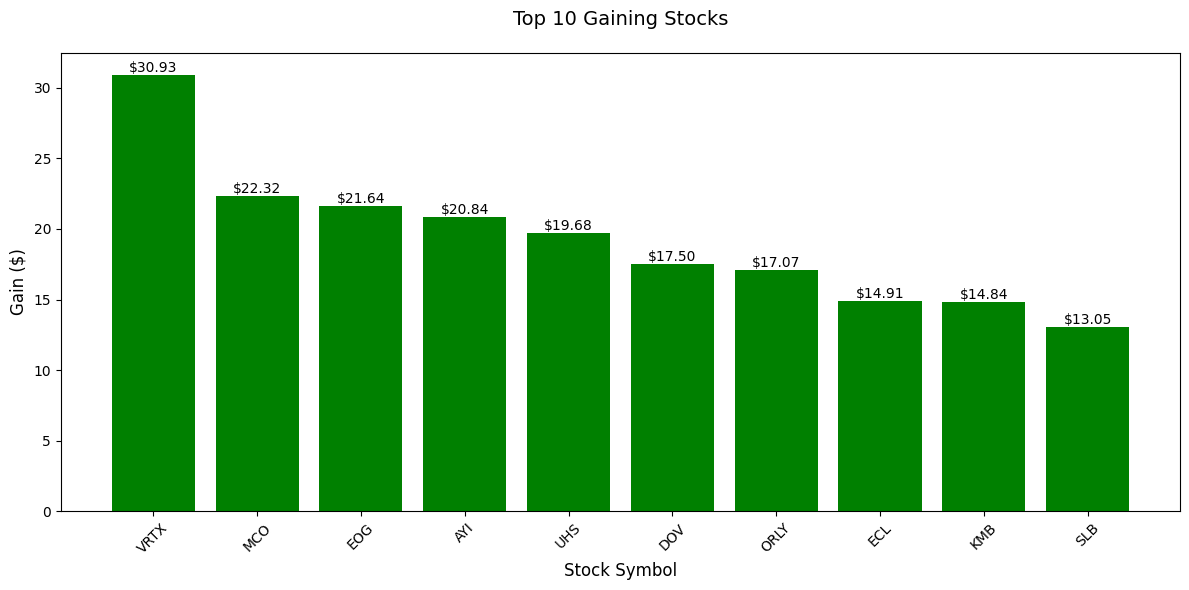

2024-12-04 19:43:31,923 - INFO - Received command c on object id p9
2024-12-04 19:43:36,273 - INFO - Top Gainers: [('AZO', 72.93), ('ADS', 66.09), ('WYNN', 44.000000000000014), ('ILMN', 33.37), ('VRTX', 30.93), ('ROK', 23.298999999999992), ('MCO', 22.32), ('EOG', 21.64), ('AYI', 20.83999999999999), ('MA', 20.684999999999995)]


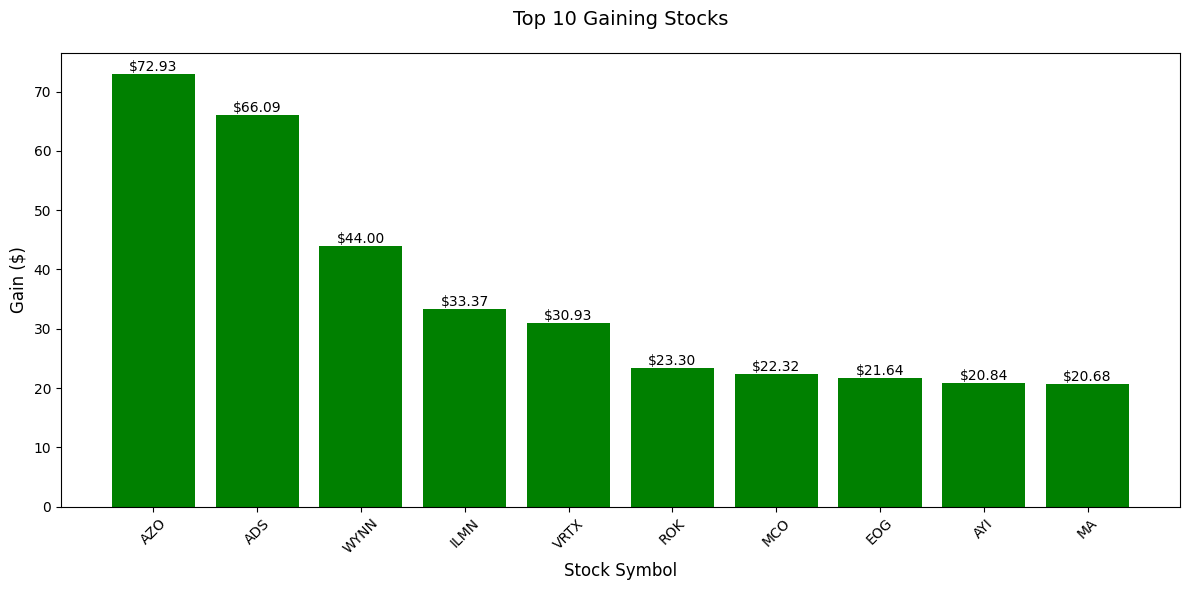

2024-12-04 19:43:37,322 - INFO - Received command c on object id p9
2024-12-04 19:43:40,054 - INFO - Stopping query...              (101 + 8) / 200]
2024-12-04 19:43:41,897 - INFO - Top Gainers: [('PCLN', 345.5999999999999), ('AZO', 72.93), ('ADS', 66.09), ('WYNN', 44.000000000000014), ('ILMN', 33.37), ('VRTX', 30.93), ('RE', 29.745000000000005), ('WDC', 28.799999999999997), ('NOC', 27.570000000000007), ('NFLX', 25.54)]


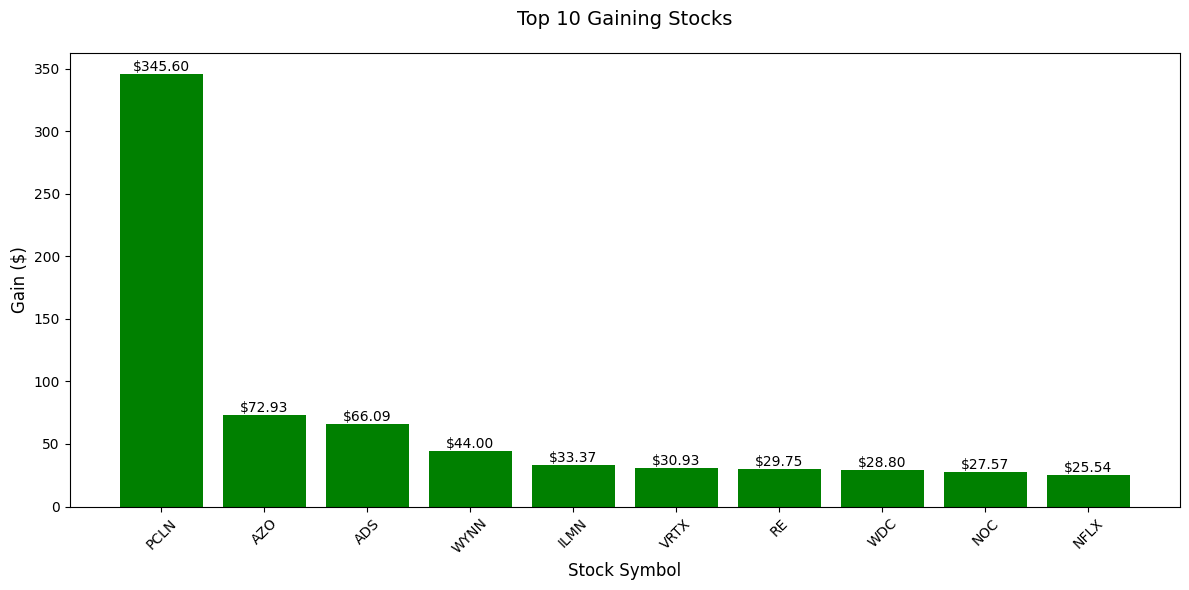

2024-12-04 19:43:43,047 - INFO - Query execution completed.
2024-12-04 19:44:22,189 - INFO - Received command  on object id 
2024-12-04 19:44:22,192 - INFO - Closing down callback connection


## TASK 4

In [5]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [ ]:
from pyspark.sql.functions import window, col, first, last
import matplotlib.pyplot as plt

# Defining the windowed data with appropriate watermark
windowed_data = df.withWatermark("timestamp", "5 minutes") \
                  .groupBy(window("timestamp", "5 minutes"), col("name")) \
                  .agg((((first(df.price) - last(df.price)) / first(df.price)) * 100).alias("value_change"))

# Defining the threshold for acceptable percentage change
threshold = 5  # A 5% change threshold is used in this example

# Filtering the data for stocks that did not lose too much value
control_pass = windowed_data.filter(col("value_change") >= -threshold)

# Visualization function
def visualize_batch(batch_df, epoch_id):
    try:
        # Collect data for visualization
        data = batch_df.collect()
        
        if data:
            names = [row["name"] for row in data]
            changes = [row["value_change"] for row in data]

            # Plot the data
            plt.figure(figsize=(10, 6))
            bars = plt.bar(names, changes, color=["green" if change >= 0 else "red" for change in changes])
            plt.xlabel("Stock Name")
            plt.ylabel("Percentage Change")
            plt.title("Stocks with Percentage Changes")
            plt.xticks(rotation=45)

            # Annotate bars with values
            for bar, change in zip(bars, changes):
                plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), f"{change:.2f}%", ha="center", va="bottom")

            plt.tight_layout()
            plt.show()
        else:
            print("No data to visualize for this batch.")
    except Exception as e:
        print(f"Error during visualization: {e}")

# Starting the streaming query
query = control_pass.writeStream \
                .outputMode("update") \
                .foreachBatch(visualize_batch) \
                .format("console") \
                .start()

query.awaitTermination()


24/12/04 20:21:31 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-02c61b59-3b38-4dc2-a276-8821161a4b50. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 58
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-03 12:00...| TMO|                 0.0|
|[2024-12-03 12:00...|  KR| -0.4517356157869656|
|[2024-12-03 12:00...|  IR|   3.462766851571696|
|[2024-12-03 12:00...|FAST|                 0.0|
|[2024-12-03 12:00...|WYNN| -2.8921091086215296|
|[2024-12-03 12:00...| WMB|   4.007581911724876|
|[2024-12-03 12:00...| GPC|  -4.704679110202003|
|[2024-12-03 12:00...|ESRX|-0.01480165778565...|
|[2024-12-03 12:00...| DHI|  11.988054607508541|
|[2024-12-03 12:00...|ANDV|                 0.0|
|[2024-12-03 12:00...| MTD|                 0.0|
|[2024-12-03 12:00...|ORCL|  -3.729913017838716|
|[2024-12-03 12:00...|COTY|  -2.939297124600633|
|[2024-12-03 12:00...|NTAP|  0.2696739396910994|
|[2024-12-03 12:00...| ETR|  10.614285714285714|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 59
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-03 12:00...| AEP|  -4.204958084906094|
|[2024-12-03 12:00...| FTI|   5.855338691159577|
|[2024-12-03 12:00...| KSU|   4.454220511410503|
|[2024-12-03 12:00...|QCOM|                 0.0|
|[2024-12-03 12:00...| MTB|-0.14515027322404517|
|[2024-12-03 12:00...| CMS|  1.7850900272676058|
|[2024-12-03 12:00...| LOW|  -4.131516331386554|
|[2024-12-03 12:00...|  KR|  12.577270565858296|
|[2024-12-03 12:00...| MHK|  -3.631424690828517|
|[2024-12-03 12:00...| MDT|  0.5708529214237801|
|[2024-12-03 12:00...| NEM|   5.182926829268291|
|[2024-12-03 12:00...|VRSN|                 0.0|
|[2024-12-03 12:00...| AMP|                 0.0|
|[2024-12-03 12:00...|  PM|                 0.0|
|[2024-12-03 12:00...|  XL| -2.2412656558998014|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 0
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 15:30...|FLIR|                0.0|
|[2024-12-02 15:25...|ADBE|                0.0|
|[2024-12-02 15:30...| CBG|                0.0|
|[2024-12-02 15:25...| AZO|                0.0|
|[2024-12-02 15:25...| HAS|                0.0|
|[2024-12-02 15:30...| DFS|                0.0|
|[2024-12-02 15:30...| NEM|                0.0|
|[2024-12-02 15:30...| ACN|                0.0|
|[2024-12-02 15:30...|ADSK|                0.0|
|[2024-12-02 15:30...| UAA|                0.0|
|[2024-12-02 15:25...|AMAT|                0.0|
|[2024-12-02 15:25...|  CL|                0.0|
|[2024-12-02 15:30...|CHRW|                0.0|
|[2024-12-02 15:30...| WYN|                0.0|
|[2024-12-02 15:25...| FLS|0.12471182593444556|
|[2024-12-02 15:30...| MCO|            

-------------------------------------------
Batch: 60
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-03 12:00...|  IR|-0.08404773911581301|
|[2024-12-03 12:00...| MRO|    7.97241379310345|
|[2024-12-03 12:00...| XEL|  1.3249420337860287|
|[2024-12-03 12:00...| NEM|   8.193597560975604|
|[2024-12-03 12:00...| PVH|                 0.0|
|[2024-12-03 12:00...| COO|-0.30065669752353463|
|[2024-12-03 12:00...|  SO|  14.229453829412364|
|[2024-12-03 12:00...| AMP|   4.778575179415375|
|[2024-12-03 12:00...| WMT| -3.1497136623943307|
|[2024-12-03 12:00...|  PM|    5.97279716144293|
|[2024-12-03 12:00...|COTY|  3.8977635782747684|
|[2024-12-03 12:00...|   L|-0.04445432318292069|
|[2024-12-03 12:00...| IPG| -4.1348600508905875|
|[2024-12-03 12:00...| SCG|  11.547311575487193|
|[2024-12-03 12:00...| NFX|  -2.984447246742332|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 1
-------------------------------------------
+--------------------+----+------------------+
|              window|name|      value_change|
+--------------------+----+------------------+
|[2024-12-02 15:30...| PEG|               0.0|
|[2024-12-02 15:30...| YUM|               0.0|
|[2024-12-02 15:30...| TRV|               0.0|
|[2024-12-02 15:30...| DAL| 7.922535211267603|
|[2024-12-02 15:30...| REG|               0.0|
|[2024-12-02 15:30...| SYK|               0.0|
|[2024-12-02 15:30...| BLL|               0.0|
|[2024-12-02 15:30...| SWK|               0.0|
|[2024-12-02 15:30...|AKAM|               0.0|
|[2024-12-02 15:30...| VAR|0.6228373702422184|
|[2024-12-02 15:30...| MGM|               0.0|
|[2024-12-02 15:30...| NOV|               0.0|
|[2024-12-02 15:30...| DPS|               0.0|
|[2024-12-02 15:30...| BXP|               0.0|
|[2024-12-02 15:30...| KSS|               0.0|
|[2024-12-02 15:30...| XEL|               0.0|
|[2024-12-

-------------------------------------------
Batch: 61
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-03 12:00...| LEG|-0.00628377529219...|
|[2024-12-03 12:00...| FTI|   1.377726750861077|
|[2024-12-03 12:00...| MDT|  -1.561450638012088|
|[2024-12-03 12:00...|ATVI|                 0.0|
|[2024-12-03 12:00...| CVX|                 0.0|
|[2024-12-03 12:00...| NEM|   6.249999999999989|
|[2024-12-03 12:00...|CERN|                 0.0|
|[2024-12-03 12:00...| RHI|                 0.0|
|[2024-12-03 12:00...|  XL| -0.7580751483190522|
|[2024-12-03 12:00...| MTD|  0.4567124714554764|
|[2024-12-03 12:00...|  VZ|  13.328369322412502|
|[2024-12-03 12:00...| CNP| 0.16891891891891533|
|[2024-12-03 12:00...| SCG|   6.287861000234791|
|[2024-12-03 12:00...|VRSK|  0.9582155199497322|
|[2024-12-03 12:00...| JPM| -3.7779767233661583|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 2
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 15:30...| YUM|-0.6580829756795332|
|[2024-12-02 15:30...| EMN|                0.0|
|[2024-12-02 15:30...|VRTX|                0.0|
|[2024-12-02 15:30...| ESS|                0.0|
|[2024-12-02 15:30...| REG| -2.688375615297239|
|[2024-12-02 15:30...|NCLH|                0.0|
|[2024-12-02 15:30...| SYK| 0.3996311097448587|
|[2024-12-02 15:30...| CMG| -3.106267029972746|
|[2024-12-02 15:30...| HCP|                0.0|
|[2024-12-02 15:30...| IVZ|                0.0|
|[2024-12-02 15:30...|ORLY|                0.0|
|[2024-12-02 15:30...| BXP|  0.799273387829242|
|[2024-12-02 15:30...| MAT|                0.0|
|[2024-12-02 15:30...|CHTR|                0.0|
|[2024-12-02 15:30...| XYL| -0.543675244653855|
|[2024-12-02 15:30...|  DG|-1.810941499

-------------------------------------------
Batch: 62
-------------------------------------------
+--------------------+-----+--------------------+
|              window| name|        value_change|
+--------------------+-----+--------------------+
|[2024-12-03 12:00...|DISCA| -3.1269543464665412|
|[2024-12-03 12:00...|  GPS|   5.330438977327547|
|[2024-12-03 12:00...|  FTI| -1.5499425947187184|
|[2024-12-03 12:00...|  MHK|-0.00714847380085...|
|[2024-12-03 12:00...|  KMI|  16.415239069291747|
|[2024-12-03 12:00...|  MRO|  1.2137931034482696|
|[2024-12-03 12:00...|  XEL|  -2.451142762504135|
|[2024-12-03 12:00...|  NEM|  6.7835365853658445|
|[2024-12-03 12:00...|  ZTS|  10.347930413917224|
|[2024-12-03 12:00...|   PM|   2.424600827912475|
|[2024-12-03 12:00...|  AMT|  -4.486299096817666|
|[2024-12-03 12:00...|  MAT|   14.33970653623832|
|[2024-12-03 12:00...| EBAY| -0.8804108584005812|
|[2024-12-03 12:00...|  IPG|  -4.516539440203556|
|[2024-12-03 12:00...| NTAP|   8.531502819318453|
|[

-------------------------------------------
Batch: 3
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-02 15:30...| JEC|                 0.0|
|[2024-12-02 15:30...|PCLN|                 0.0|
|[2024-12-02 15:30...| ESS| -0.6140097084257643|
|[2024-12-02 15:30...| REG|   3.351192730026504|
|[2024-12-02 15:30...|  LB|                 0.0|
|[2024-12-02 15:30...| HIG|                 0.0|
|[2024-12-02 15:30...| NEE|  1.0104744300677848|
|[2024-12-02 15:30...|ORLY|  1.7027725773379658|
|[2024-12-02 15:30...| BXP| -2.4023614895549597|
|[2024-12-02 15:30...| ADS|                 0.0|
|[2024-12-02 15:30...| PKG|                 0.0|
|[2024-12-02 15:30...| MAT| -1.6229435304579902|
|[2024-12-02 15:30...| XYL| -1.3410656034795252|
|[2024-12-02 15:30...| CHD|                 0.0|
|[2024-12-02 15:30...|  HD|                 0.0|
|[2024-12-02 15:30...

-------------------------------------------
Batch: 63
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-03 12:00...|DISCA|  4.727954971857412|
|[2024-12-03 12:00...| ULTA| 0.6109510086455345|
|[2024-12-03 12:00...|    K| -2.679723677218554|
|[2024-12-03 12:00...|  LOW| 1.1680726800778698|
|[2024-12-03 12:00...|  HAS| -2.609026852028194|
|[2024-12-03 12:00...|  MHK| 3.6743155336335596|
|[2024-12-03 12:00...|   IR|-1.3279542780299196|
|[2024-12-03 12:00...|  MRO|-0.5793103448275886|
|[2024-12-03 12:00...| ANSS|   2.61895501102035|
|[2024-12-03 12:00...|  WMT| -4.131442596127626|
|[2024-12-03 12:00...|   PM|-2.7794204612655338|
|[2024-12-03 12:00...|  PLD|                0.0|
|[2024-12-03 12:00...|  PGR| 0.4672897196261721|
|[2024-12-03 12:00...|  MAT| 14.539795464650956|
|[2024-12-03 12:00...|  KIM| -4.156257097433564|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 4
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 15:30...|  BK|                0.0|
|[2024-12-02 15:30...|PRGO|                0.0|
|[2024-12-02 15:30...| ESS| 2.6874979908059324|
|[2024-12-02 15:30...|  LB| 1.7094017094017007|
|[2024-12-02 15:30...| SYK| -4.949277589916997|
|[2024-12-02 15:30...| GLW|                0.0|
|[2024-12-02 15:30...| HCP| 12.902625209458202|
|[2024-12-02 15:30...| NEE|-3.6845348120763957|
|[2024-12-02 15:30...|CHRW| -4.392943618125215|
|[2024-12-02 15:30...| APH|                0.0|
|[2024-12-02 15:30...| AMD|                0.0|
|[2024-12-02 15:30...| NUE|                0.0|
|[2024-12-02 15:30...| XYL|  3.479521565784708|
|[2024-12-02 15:30...|  WM|                0.0|
|[2024-12-02 15:30...|  HD|   2.03896103896103|
|[2024-12-02 15:30...| AAP|            

-------------------------------------------
Batch: 64
-------------------------------------------
+--------------------+-----+--------------------+
|              window| name|        value_change|
+--------------------+-----+--------------------+
|[2024-12-03 12:00...|DISCA| -0.8880550343964899|
|[2024-12-03 12:00...|  GPS|-0.36179450072358554|
|[2024-12-03 12:00...|    T|   7.031042716901031|
|[2024-12-03 12:00...|  LOW|  0.8652390222799018|
|[2024-12-03 12:00...| CSCO|  0.1620089104900879|
|[2024-12-03 12:00...|  STT|  3.6095870632399647|
|[2024-12-03 12:00...|  NEM|   12.27134146341463|
|[2024-12-03 12:00...|  PVH|  1.6662458975006345|
|[2024-12-03 12:00...|  AMP|  -2.319271836163129|
|[2024-12-03 12:00...|  EXC|  1.9478774852230023|
|[2024-12-03 12:00...|   PM|  -4.742755765819048|
|[2024-12-03 12:00...|  PGR|  1.3629283489096629|
|[2024-12-03 12:00...|  WYN| -1.6609938733832523|
|[2024-12-03 12:00...|  MKC|  -1.773301177471982|
|[2024-12-03 12:00...|   WU|   8.872767857142875|
|[

-------------------------------------------
Batch: 5
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 15:30...| CBG| 1.2903225806451624|
|[2024-12-02 15:30...| ESS|-2.9093130163628804|
|[2024-12-02 15:30...| ACN|  4.285714285714282|
|[2024-12-02 15:30...| CPB|                0.0|
|[2024-12-02 15:30...| SWK|-3.2019704433497465|
|[2024-12-02 15:30...| NOV|-3.9636127355425668|
|[2024-12-02 15:30...|ROST|                0.0|
|[2024-12-02 15:30...| IRM|                0.0|
|[2024-12-02 15:30...|BF.B|                0.0|
|[2024-12-02 15:30...|  HD| -3.974025974025977|
|[2024-12-02 15:30...| AAL|                0.0|
|[2024-12-02 15:30...|   K|                0.0|
|[2024-12-02 15:30...| UTX|                0.0|
|[2024-12-02 15:30...| PNW|                0.0|
|[2024-12-02 15:30...| MOS|                0.0|
|[2024-12-02 15:30...| LEG| 2.035943194

-------------------------------------------
Batch: 65
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...|JBHT|-1.4517006802720995|
|[2024-12-03 12:00...| MTB| -4.311816939890708|
|[2024-12-03 12:00...|   T|  4.828867073494297|
|[2024-12-03 12:00...|   K|-1.3132923403932426|
|[2024-12-03 12:00...|CSCO|-3.8882138517618356|
|[2024-12-03 12:00...|ESRX|-3.0787448194197724|
|[2024-12-03 12:00...| EFX|                0.0|
|[2024-12-03 12:00...|NTAP|  7.060554057367008|
|[2024-12-03 12:00...| MAA| 2.4552975713904504|
|[2024-12-03 12:00...| MKC|-1.3193360760391644|
|[2024-12-03 12:00...| STX|                0.0|
|[2024-12-03 12:00...|  WU| 1.5904017857142863|
|[2024-12-03 12:00...| RHT|  7.218221403450012|
|[2024-12-03 12:00...| JPM|  -3.31244404655327|
|[2024-12-03 12:00...|  LH| -4.131227217496961|
|[2024-12-03 12:00...| TRV|           

-------------------------------------------
Batch: 6
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 15:35...| RRC|                0.0|
|[2024-12-02 15:35...| CMI|                0.0|
|[2024-12-02 15:30...| WEC|                0.0|
|[2024-12-02 15:35...| TEL|                0.0|
|[2024-12-02 15:35...| DFS|                0.0|
|[2024-12-02 15:35...| CAH|                0.0|
|[2024-12-02 15:35...| BLL|                0.0|
|[2024-12-02 15:35...| AME|                0.0|
|[2024-12-02 15:35...| PSA|                0.0|
|[2024-12-02 15:35...| NBL| -3.534538411878639|
|[2024-12-02 15:30...| WBA|                0.0|
|[2024-12-02 15:30...| TWX|                0.0|
|[2024-12-02 15:35...| OMC|                0.0|
|[2024-12-02 15:35...| ADM|                0.0|
|[2024-12-02 15:35...| PPL|                0.0|
|[2024-12-02 15:35...| XEL|            

-------------------------------------------
Batch: 66
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...|   K|0.20496470052378488|
|[2024-12-03 12:00...|CSCO|-2.7541514783313072|
|[2024-12-03 12:00...| STT| -1.949177014149573|
|[2024-12-03 12:00...| ABC|                0.0|
|[2024-12-03 12:00...| NEM| 1.9435975609756024|
|[2024-12-03 12:00...|CERN|  3.919765984120361|
|[2024-12-03 12:00...|VRSN|   8.69063324538259|
|[2024-12-03 12:00...|TROW|                0.0|
|[2024-12-03 12:00...| CLX| -4.027777777777765|
|[2024-12-03 12:00...| EXC|  15.30091348737238|
|[2024-12-03 12:00...| EFX| -3.521320495185697|
|[2024-12-03 12:00...| PGR|  8.566978193146415|
|[2024-12-03 12:00...|  PG|-1.2100369379696707|
|[2024-12-03 12:00...|PDCO|  4.341603053435115|
|[2024-12-03 12:00...| SCG| 2.0051655318149715|
|[2024-12-03 12:00...| RHT| 0.58616647

-------------------------------------------
Batch: 7
-------------------------------------------
+--------------------+-----+-----------------+
|              window| name|     value_change|
+--------------------+-----+-----------------+
|[2024-12-02 18:35...|  USB|              0.0|
|[2024-12-02 15:35...|  WEC|              0.0|
|[2024-12-02 15:35...|  AON|              0.0|
|[2024-12-02 15:35...|  CCI|              0.0|
|[2024-12-02 20:05...|  GPC|              0.0|
|[2024-12-02 18:35...| JNPR|              0.0|
|[2024-12-02 15:35...|  BLL|-2.33995584988963|
|[2024-12-02 15:35...| ORCL|              0.0|
|[2024-12-02 15:35...|GOOGL|              0.0|
|[2024-12-02 18:35...|  NSC|              0.0|
|[2024-12-02 20:05...|  EMR|              0.0|
|[2024-12-02 20:05...|  WMT|              0.0|
|[2024-12-02 20:05...|  DFS|              0.0|
|[2024-12-02 15:35...| PRGO|              0.0|
|[2024-12-02 18:35...|  SLB|              0.0|
|[2024-12-02 15:35...|  TXT|              0.0|
|[2024-12-

-------------------------------------------
Batch: 67
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...| EQR|                0.0|
|[2024-12-03 12:00...|CSCO| -2.065613608748473|
|[2024-12-03 12:00...| KMI| -3.963180772181021|
|[2024-12-03 12:00...| ETN|0.38532895675752254|
|[2024-12-03 12:00...| MAT| 23.743886171631836|
|[2024-12-03 12:00...| SYF|                0.0|
|[2024-12-03 12:00...| MAA|  7.859621030157459|
|[2024-12-03 12:00...|  WU|  6.417410714285726|
|[2024-12-03 12:00...|VIAB| -2.372331127481573|
|[2024-12-03 12:00...| PCG| -4.838709677419344|
|[2024-12-03 12:00...|  GE| 1.7669172932330919|
|[2024-12-03 12:00...| KMB|-3.3072817384674025|
|[2024-12-03 12:00...| BBY|                0.0|
|[2024-12-03 12:00...| ALB|-0.5050505050505055|
|[2024-12-03 12:00...| ROK| -4.672913845934591|
|[2024-12-03 12:00...| IBM|  10.019813

-------------------------------------------
Batch: 8
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-02 20:05...| UNP|                 0.0|
|[2024-12-02 20:05...|SBAC|                 0.0|
|[2024-12-02 20:05...|  MA|                 0.0|
|[2024-12-02 20:05...| CMI|                 0.0|
|[2024-12-02 20:05...| AEP|                 0.0|
|[2024-12-02 20:05...|  BA|                 0.0|
|[2024-12-02 20:05...| BLL|                 0.0|
|[2024-12-02 20:05...| GPC|0.012403870007448668|
|[2024-12-02 20:05...| DHR|                 0.0|
|[2024-12-02 20:05...| EOG|                 0.0|
|[2024-12-02 20:05...| MHK|                 0.0|
|[2024-12-02 20:05...| CMA|                 0.0|
|[2024-12-02 20:05...| CHK|                 0.0|
|[2024-12-02 20:05...|FOXA|                 0.0|
|[2024-12-02 20:05...| ROP|                 0.0|
|[2024-12-02 20:05...

-------------------------------------------
Batch: 68
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...|JBHT|-1.1972789115646196|
|[2024-12-03 12:00...| RTN|  5.128038578880031|
|[2024-12-03 12:00...| XOM|-2.6298415492957754|
|[2024-12-03 12:00...| PVH| -4.098291677185899|
|[2024-12-03 12:00...| AMP|-0.9802205496236569|
|[2024-12-03 12:00...| KEY|-1.5234374999999885|
|[2024-12-03 12:00...|JNPR| -4.764150943396234|
|[2024-12-03 12:00...|NTAP|  4.756067663643044|
|[2024-12-03 12:00...| KIM|-0.1135589370883424|
|[2024-12-03 12:00...|  GM|-1.7215342796738156|
|[2024-12-03 12:00...| SWK| -4.880668257756567|
|[2024-12-03 12:00...| HCN| 14.420421634000133|
|[2024-12-03 12:00...| BBY|  5.132905591200722|
|[2024-12-03 12:00...| APA| 15.066418084362612|
|[2024-12-03 12:00...|   F| 18.255813953488364|
|[2024-12-03 12:00...| RMD|0.059488399

-------------------------------------------
Batch: 9
-------------------------------------------
+--------------------+----+------------------+
|              window|name|      value_change|
+--------------------+----+------------------+
|[2024-12-02 20:10...|FOXA|               0.0|
|[2024-12-02 20:10...| JCI|0.6579443386126395|
|[2024-12-02 20:10...| EQT|               0.0|
|[2024-12-02 20:10...|FITB|               0.0|
|[2024-12-02 20:10...| FOX|               0.0|
|[2024-12-02 20:10...| MLM|               0.0|
|[2024-12-02 20:10...|COTY|               0.0|
|[2024-12-02 20:10...|AKAM|               0.0|
|[2024-12-02 20:05...|  KR|               0.0|
|[2024-12-02 20:10...| STZ|               0.0|
|[2024-12-02 20:10...| MTD|               0.0|
|[2024-12-02 20:10...| VAR|               0.0|
|[2024-12-02 20:10...|  PH|               0.0|
|[2024-12-02 20:10...|ESRX|               0.0|
|[2024-12-02 20:10...| UAA|               0.0|
|[2024-12-02 20:05...| IBM|               0.0|
|[2024-12-

2024-12-04 20:23:30,341 - INFO - Callback Connection ready to receive messages1]
2024-12-04 20:23:30,396 - INFO - Received command g on object id p1 (0 + 0) / 1]


-------------------------------------------
Batch: 69
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-03 12:00...|DISCA| 59.124452782989366|
|[2024-12-03 12:00...| INFO|                0.0|
|[2024-12-03 12:00...| FLIR|  8.814589665653491|
|[2024-12-03 12:00...|  GPS|   8.12831644958996|
|[2024-12-03 12:00...|  TMK|   0.79985119047619|
|[2024-12-03 12:00...| TROW|-0.1150747986191068|
|[2024-12-03 12:00...| PDCO|-0.7156488549618253|
|[2024-12-03 12:00...|  LLY|                0.0|
|[2024-12-03 12:00...|  RRC|  9.427820207837737|
|[2024-12-03 12:00...| CINF|  6.924528301886795|
|[2024-12-03 12:00...|  GIS| -0.790369096231849|
|[2024-12-03 12:00...|  NBL| 10.087153001936732|
|[2024-12-03 12:00...|  HCN|  4.068161918232635|
|[2024-12-03 12:00...| FBHS|  7.897071872227142|
|[2024-12-03 12:00...|  CPB| 3.3512352309344693|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 10
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 20:10...|FOXA| -4.803362353647536|
|[2024-12-02 20:10...| SEE|                0.0|
|[2024-12-02 20:10...|FITB|-2.4478914202617674|
|[2024-12-02 20:10...|  MU|                0.0|
|[2024-12-02 20:10...| CMG|                0.0|
|[2024-12-02 20:10...| AAP|                0.0|
|[2024-12-02 20:10...| ETR|                0.0|
|[2024-12-02 20:10...|FAST|                0.0|
|[2024-12-02 20:10...| VNO|                0.0|
|[2024-12-02 20:10...|  PM|                0.0|
|[2024-12-02 20:10...| BWA|                0.0|
|[2024-12-02 20:10...| NEM|                0.0|
|[2024-12-02 20:10...|CHRW|                0.0|
|[2024-12-02 20:10...| NKE|                0.0|
|[2024-12-02 20:10...| FCX|                0.0|
|[2024-12-02 20:10...| DAL|           

-------------------------------------------
Batch: 70
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...| GPS|  4.365653642064646|
|[2024-12-03 12:00...| FTI|-1.9613471106008393|
|[2024-12-03 12:00...| XOM|0.16505281690139909|
|[2024-12-03 12:00...| HRL|                0.0|
|[2024-12-03 12:00...| KMI| -2.838148811045767|
|[2024-12-03 12:00...|FAST| -0.630571863448574|
|[2024-12-03 12:00...| MRO|  22.84137931034483|
|[2024-12-03 12:00...| CVX|-0.5326344267838987|
|[2024-12-03 12:00...|VRSN| 0.6431398416886552|
|[2024-12-03 12:00...| EXC|  4.110693175711986|
|[2024-12-03 12:00...|EBAY| -2.090975788701382|
|[2024-12-03 12:00...|KORS| -2.441627751834554|
|[2024-12-03 12:00...| BAX|-3.3594306049822054|
|[2024-12-03 12:00...| BBT|-1.7347211102215068|
|[2024-12-03 12:00...|SBUX|-3.3090794052514956|
|[2024-12-03 12:00...|NTRS|           

-------------------------------------------
Batch: 11
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-02 20:10...|  RF|                 0.0|
|[2024-12-02 20:10...| SEE|   7.318545344801561|
|[2024-12-02 20:10...|FITB| -2.3267086766844423|
|[2024-12-02 20:10...| FOX|  2.2664624808575757|
|[2024-12-02 20:10...| NOV|                 0.0|
|[2024-12-02 20:10...|  MU| -0.7206443408223896|
|[2024-12-02 20:10...| CMG|   8.345149392742725|
|[2024-12-02 20:10...|PAYX|                 0.0|
|[2024-12-02 20:10...|FISV|-0.05330490405117...|
|[2024-12-02 20:10...| APH|                 0.0|
|[2024-12-02 20:10...| NRG|                 0.0|
|[2024-12-02 20:10...| MAC|                 0.0|
|[2024-12-02 20:10...|  PM|    5.97279716144293|
|[2024-12-02 20:10...|ABBV|   4.006284367635505|
|[2024-12-02 20:10...|AKAM|  -4.819014391626692|
|[2024-12-02 20:10..

-------------------------------------------
Batch: 71
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...|GOOG|                0.0|
|[2024-12-03 12:00...|FAST| -4.066101326375293|
|[2024-12-03 12:00...| CVX|   9.89178221170105|
|[2024-12-03 12:00...| TMK| 1.3020833333333255|
|[2024-12-03 12:00...|EBAY| -3.484959647835654|
|[2024-12-03 12:00...| RHT| -3.416513146876569|
|[2024-12-03 12:00...| PSX|  8.914144871970429|
|[2024-12-03 12:00...| RRC|  39.58933266558157|
|[2024-12-03 12:00...| AMD|  34.14634146341463|
|[2024-12-03 12:00...|CINF|  2.773584905660375|
|[2024-12-03 12:00...| NBL| 28.631375080697225|
|[2024-12-03 12:00...| PFE|-3.1832797427652797|
|[2024-12-03 12:00...| BBT| 3.3626901521216923|
|[2024-12-03 12:00...| DOV|  6.310987200608276|
|[2024-12-03 12:00...| ALB|   7.02335858585859|
|[2024-12-03 12:00...| CPB|-1.71858216

2024-12-04 20:24:02,478 - INFO - Received command  on object id     (0 + 0) / 1]
2024-12-04 20:24:02,492 - INFO - Closing down callback connection


-------------------------------------------
Batch: 12
-------------------------------------------
+--------------------+----+------------------+
|              window|name|      value_change|
+--------------------+----+------------------+
|[2024-12-02 20:10...|  RF| 2.262016965127241|
|[2024-12-02 20:10...| FOX|-3.124042879019918|
|[2024-12-02 20:10...|NWSA|               0.0|
|[2024-12-02 20:10...|PAYX| 1.284317190998001|
|[2024-12-02 20:10...|COTY| 6.641837368094353|
|[2024-12-02 20:10...| MTD|0.4567124714554764|
|[2024-12-02 20:10...| NEM| 3.175241157556267|
|[2024-12-02 20:10...|  VZ|               0.0|
|[2024-12-02 20:10...|ORLY| 4.291887011479428|
|[2024-12-02 20:10...| AAL|               0.0|
|[2024-12-02 20:10...|  WM|               0.0|
|[2024-12-02 20:10...|  WY| 2.026143790849676|
|[2024-12-02 20:10...|DISH|               0.0|
|[2024-12-02 20:10...| PCG|               0.0|
|[2024-12-02 20:10...|  XL| 1.450676982591874|
|[2024-12-02 20:10...|  BK| 3.117782909930711|
|[2024-12

-------------------------------------------
Batch: 72
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...| STT| -4.389257868899786|
|[2024-12-03 12:00...|FAST|  6.653620352250495|
|[2024-12-03 12:00...|WYNN|  4.584754018509499|
|[2024-12-03 12:00...| CFG|                0.0|
|[2024-12-03 12:00...| NEM|  6.249999999999989|
|[2024-12-03 12:00...| MAT| 39.484215206758556|
|[2024-12-03 12:00...| NOV| 26.826265389876873|
|[2024-12-03 12:00...| RRC|  40.09014648804307|
|[2024-12-03 12:00...|  GE| 7.7924812030075215|
|[2024-12-03 12:00...|KORS|  5.737158105403598|
|[2024-12-03 12:00...| BAX|-0.9252669039145989|
|[2024-12-03 12:00...| ALB| 13.573232323232325|
|[2024-12-03 12:00...| HAL| 30.132501948558073|
|[2024-12-03 12:00...|   F|  6.162790697674411|
|[2024-12-03 12:00...| LKQ| 17.842498505678428|
|[2024-12-03 12:00...| FLS| 11.0057515

-------------------------------------------
Batch: 13
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-02 20:10...|  GLW|                0.0|
|[2024-12-02 20:10...| FFIV|-1.6755096341803937|
|[2024-12-02 20:10...| FISV|-1.8656716417910397|
|[2024-12-02 20:10...|   PM|  2.424600827912475|
|[2024-12-02 20:10...|  NEM| 1.6881028938906677|
|[2024-12-02 20:10...|  CHK|   7.60573606825196|
|[2024-12-02 20:10...|  KIM|                0.0|
|[2024-12-02 20:10...|   GD|                0.0|
|[2024-12-02 20:10...|  HON|                0.0|
|[2024-12-02 20:10...|   IT|                0.0|
|[2024-12-02 20:10...|DISCA|                0.0|
|[2024-12-02 20:10...|  FCX|  6.182721501518065|
|[2024-12-02 20:10...|  UNM|                0.0|
|[2024-12-02 20:10...| NFLX| 1.4204330692635525|
|[2024-12-02 20:10...|  EMN|                0.0|
|[2024-12-02 20:10..

-------------------------------------------
Batch: 73
-------------------------------------------
+--------------------+-----+--------------------+
|              window| name|        value_change|
+--------------------+-----+--------------------+
|[2024-12-03 12:00...| FLIR|  3.6684823497547363|
|[2024-12-03 12:00...| QCOM|   4.442393883469555|
|[2024-12-03 12:00...| WYNN|  12.244276668290315|
|[2024-12-03 12:00...|  EQT| -1.4459758798917022|
|[2024-12-03 12:00...|   RL|  26.175902950096496|
|[2024-12-03 12:00...|  MKC|  -3.078450844091363|
|[2024-12-03 12:00...|DISCK|  58.578011849901245|
|[2024-12-03 12:00...|  ROK|   -3.85341694577069|
|[2024-12-03 12:00...|  APA|  27.837333954789088|
|[2024-12-03 12:00...|   FE|   5.389876880984949|
|[2024-12-03 12:00...|    F|   5.813953488372093|
|[2024-12-03 12:00...|  NWS|  3.7212049616066096|
|[2024-12-03 12:00...|  PWR|   7.062706270627064|
|[2024-12-03 12:00...|   DE|-0.01116071428571...|
|[2024-12-03 12:00...|    A|  2.2727272727272774|
|[

-------------------------------------------
Batch: 14
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-02 20:10...|   GE|                0.0|
|[2024-12-02 20:10...| FFIV| 2.9693754072419356|
|[2024-12-02 20:10...| EBAY|                0.0|
|[2024-12-02 20:10...|   PM|-2.7794204612655338|
|[2024-12-02 20:10...|  HIG|                0.0|
|[2024-12-02 20:10...|  AMT|                0.0|
|[2024-12-02 20:10...|  KIM| -4.156257097433564|
|[2024-12-02 20:10...|   GD|-3.2622679654475384|
|[2024-12-02 20:10...|  AAL|-0.9340659340659434|
|[2024-12-02 20:10...|   IT|  6.933406412715816|
|[2024-12-02 20:10...|DISCA| 7.6167374166161315|
|[2024-12-02 20:10...|  UNM|  6.846240179573507|
|[2024-12-02 20:10...|   WY|  5.882352941176473|
|[2024-12-02 20:10...|   LB|                0.0|
|[2024-12-02 20:10...|  PCG|-0.0681508405270196|
|[2024-12-02 20:10..

-------------------------------------------
Batch: 74
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...| XOM|   5.61168573943661|
|[2024-12-03 12:00...| MRK|                0.0|
|[2024-12-03 12:00...| NEM| 12.690548780487799|
|[2024-12-03 12:00...|  PM|  5.199172087522173|
|[2024-12-03 12:00...| SNI| -4.752004752004756|
|[2024-12-03 12:00...|  VZ|  8.514147431124346|
|[2024-12-03 12:00...| APC|  1.278096077567222|
|[2024-12-03 12:00...| NOV| 22.804377564979475|
|[2024-12-03 12:00...|CINF| -3.622641509433965|
|[2024-12-03 12:00...| LKQ| 22.952779438135085|
|[2024-12-03 12:00...|SYMC|-0.4401760704281833|
|[2024-12-03 12:00...| BAC| 0.5635566687539127|
+--------------------+----+-------------------+



-------------------------------------------
Batch: 15
-------------------------------------------
+--------------------+----+------------------+
|              window|name|      value_change|
+--------------------+----+------------------+
|[2024-12-02 20:15...| TIF|               0.0|
|[2024-12-02 20:10...| CMG| 6.134043662916326|
|[2024-12-02 20:15...| ADM|               0.0|
|[2024-12-02 20:15...|  EL|               0.0|
|[2024-12-02 20:10...| HOG|               0.0|
|[2024-12-02 20:15...| PPL|               0.0|
|[2024-12-02 20:15...| BDX|               0.0|
|[2024-12-02 20:15...| RHI|               0.0|
|[2024-12-02 20:15...|ULTA|               0.0|
|[2024-12-02 20:15...| CVX|               0.0|
|[2024-12-02 20:10...|CHRW|-2.752770083102499|
|[2024-12-02 20:15...| TWX|               0.0|
|[2024-12-02 20:15...| BSX|               0.0|
|[2024-12-02 20:15...| BLL|               0.0|
|[2024-12-02 20:15...|NFLX|               0.0|
|[2024-12-02 20:10...| FCX|3.7537951973502612|
|[2024-12

-------------------------------------------
Batch: 75
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-03 12:00...|DISCA| 58.630393996247655|
|[2024-12-03 12:00...| ISRG| -4.564393090639306|
|[2024-12-03 12:00...|  RTN|-4.7141029426237635|
|[2024-12-03 12:00...|  XOM|  2.431778169014078|
|[2024-12-03 12:00...|  MTB| -4.994877049180323|
|[2024-12-03 12:00...| QRVO|                0.0|
|[2024-12-03 12:00...|  MRO| 24.110344827586204|
|[2024-12-03 12:00...|   PM| -2.554701360141924|
|[2024-12-03 12:00...|  ETN| 0.7563864706721664|
|[2024-12-03 12:00...|  MAT| 39.884393063583815|
|[2024-12-03 12:00...|   PG| -2.725767418163292|
|[2024-12-03 12:00...|  OXY|   5.64822270792593|
|[2024-12-03 12:00...| NTAP|  10.12503064476588|
|[2024-12-03 12:00...|  SYY|0.21609940572664882|
|[2024-12-03 12:00...|   GE| -4.135338345864653|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 16
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 20:15...| SRE|                0.0|
|[2024-12-02 20:15...| AIG|                0.0|
|[2024-12-02 20:15...| DPS|                0.0|
|[2024-12-02 20:15...| OMC|                0.0|
|[2024-12-02 20:15...| TJX|  2.288828337874656|
|[2024-12-02 20:15...| NOV|                0.0|
|[2024-12-02 20:15...|  EW|                0.0|
|[2024-12-02 20:15...| PPL| 1.1818968002306043|
|[2024-12-02 20:15...| BDX|-1.5425259928413178|
|[2024-12-02 20:15...|ESRX|                0.0|
|[2024-12-02 20:15...| JPM|                0.0|
|[2024-12-02 20:15...|  LB|                0.0|
|[2024-12-02 20:15...| BSX| 1.9157088122605364|
|[2024-12-02 20:15...| BLL| -3.293120313009449|
|[2024-12-02 20:15...|   D|                0.0|
|[2024-12-02 20:15...| DRE|           

-------------------------------------------
Batch: 76
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...| GWW| -4.032011195172082|
|[2024-12-03 12:00...|QCOM| 10.862114421302392|
|[2024-12-03 12:00...|   K|  5.595080847187421|
|[2024-12-03 12:00...| PVH| 10.813767567112677|
|[2024-12-03 12:00...|  SO| 11.348326251425007|
|[2024-12-03 12:00...| MAT| 40.862605602489985|
|[2024-12-03 12:00...| CTL|-1.2561274509803817|
|[2024-12-03 12:00...| OXY|   9.57091913033476|
|[2024-12-03 12:00...| APC|  7.624504186866463|
|[2024-12-03 12:00...| SCG|   4.16529701807935|
|[2024-12-03 12:00...|  GE|-3.6842105263157774|
|[2024-12-03 12:00...| NBL| 27.517753389283417|
|[2024-12-03 12:00...| COP| -2.309431524547803|
|[2024-12-03 12:00...| HCN|  6.337980736849193|
|[2024-12-03 12:00...| DOV|  2.205043720694456|
|[2024-12-03 12:00...| CPB|-3.58754027

-------------------------------------------
Batch: 17
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 20:15...|PCAR|                0.0|
|[2024-12-02 20:15...| IFF|                0.0|
|[2024-12-02 20:15...| SRE| 3.4016864699118408|
|[2024-12-02 20:15...|ALLE| 0.1350308641975314|
|[2024-12-02 20:15...| RJF|                0.0|
|[2024-12-02 20:15...|  EL| 3.2577534532186605|
|[2024-12-02 20:15...| BDX| 0.8010908471109576|
|[2024-12-02 20:15...| RHT|                0.0|
|[2024-12-02 20:15...| CSX|                0.0|
|[2024-12-02 20:15...| TWX|-2.1321660547867904|
|[2024-12-02 20:15...| CLX|                0.0|
|[2024-12-02 20:15...| AMT|                0.0|
|[2024-12-02 20:15...|VRTX|-0.5357881671493447|
|[2024-12-02 20:15...| GPN| 0.5033798360419881|
|[2024-12-02 20:15...| DRE|-3.9592760180995437|
|[2024-12-02 20:15...|CTXS|           

-------------------------------------------
Batch: 77
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-03 12:00...|GOOG|  -4.691832369484274|
|[2024-12-03 12:00...|PBCT|                 0.0|
|[2024-12-03 12:00...| COG|  18.970391310816833|
|[2024-12-03 12:00...| PVH|   2.692922662627285|
|[2024-12-03 12:00...|KLAC|   0.614790093096788|
|[2024-12-03 12:00...| PPL| -3.6829990134824104|
|[2024-12-03 12:00...| STX|  22.681929681112013|
|[2024-12-03 12:00...| SPG|-0.45701228220507445|
|[2024-12-03 12:00...| COP|   3.488372093023262|
|[2024-12-03 12:00...|  IP|   3.440553745928334|
|[2024-12-03 12:00...|   F|  13.604651162790699|
|[2024-12-03 12:00...| FLS|  15.607026270791232|
|[2024-12-03 12:00...| OKE|   28.10630613945735|
|[2024-12-03 12:00...|  RF|   6.032045240339292|
|[2024-12-03 12:00...| CAT|   1.321222130470674|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 18
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-02 20:15...|ALLE| -1.0030864197530787|
|[2024-12-02 20:15...|CTSH|                 0.0|
|[2024-12-02 20:15...| ALB|                 0.0|
|[2024-12-02 20:15...| ADI|                 0.0|
|[2024-12-02 20:15...| JPM| -3.8994800693240896|
|[2024-12-02 20:15...|VRTX|    2.25486139842781|
|[2024-12-02 20:15...| PCG|                 0.0|
|[2024-12-02 20:15...| WAT|                 0.0|
|[2024-12-02 20:15...|ZION| -3.1446540880503098|
|[2024-12-02 20:15...|FITB|                 0.0|
|[2024-12-02 20:15...| VAR|                 0.0|
|[2024-12-02 20:15...|  NI|                 0.0|
|[2024-12-02 20:15...| SLB|  -2.526547052361777|
|[2024-12-02 20:15...| JNJ|-0.13504388926401134|
|[2024-12-02 20:15...| KMB|  3.8499068570921704|
|[2024-12-02 20:15..

-------------------------------------------
Batch: 78
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...| KSU|  9.861607552011737|
|[2024-12-03 12:00...|PBCT|-1.0097919216646216|
|[2024-12-03 12:00...| COG| 23.820859991072744|
|[2024-12-03 12:00...| DVN|  16.33726201269265|
|[2024-12-03 12:00...| MRO|  51.77931034482759|
|[2024-12-03 12:00...| CVX| 26.166723030098076|
|[2024-12-03 12:00...| PVH| 2.5835226794580435|
|[2024-12-03 12:00...| CHK| 56.891191709844556|
|[2024-12-03 12:00...| EXC|  7.912412681354112|
|[2024-12-03 12:00...|  PX|-1.1112083296876332|
|[2024-12-03 12:00...| MAT|  49.71098265895953|
|[2024-12-03 12:00...| BEN| 2.8009084027252116|
|[2024-12-03 12:00...| JEC|  24.96033844526705|
|[2024-12-03 12:00...| STX| 17.497955846279634|
|[2024-12-03 12:00...| XRX| -4.356243949661174|
|[2024-12-03 12:00...|NAVI|  2.5872817

-------------------------------------------
Batch: 19
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-02 20:15...| IFF|   5.342269028243177|
|[2024-12-02 20:15...|  GM|                 0.0|
|[2024-12-02 20:15...| ARE|                 0.0|
|[2024-12-02 20:15...|HOLX|                 0.0|
|[2024-12-02 20:15...|CTSH|-0.44395116537181545|
|[2024-12-02 20:15...| APD|                 0.0|
|[2024-12-02 20:15...| UAA|                 0.0|
|[2024-12-02 20:15...| AFL|                 0.0|
|[2024-12-02 20:15...| TSS|                 0.0|
|[2024-12-02 20:15...| CMA|                 0.0|
|[2024-12-02 20:15...| NEE|   2.847743394674613|
|[2024-12-02 20:15...| GWW|                 0.0|
|[2024-12-02 20:15...| WAT|  5.1262211045555635|
|[2024-12-02 20:15...| APA| -2.4876157656687514|
|[2024-12-02 20:15...| EQT|                 0.0|
|[2024-12-02 20:15..

-------------------------------------------
Batch: 79
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-03 12:00...| VNO| -3.2988283471732522|
|[2024-12-03 12:00...| GPS|  19.729860106126385|
|[2024-12-03 12:00...| FTI|  34.615384615384606|
|[2024-12-03 12:00...|QCOM|  27.036646453994194|
|[2024-12-03 12:00...|   K|  -1.434752903666602|
|[2024-12-03 12:00...| STT|  -4.302627779382023|
|[2024-12-03 12:00...|QRVO|   35.28161270616982|
|[2024-12-03 12:00...|  IR|   7.413010590015134|
|[2024-12-03 12:00...| NEM|   37.91920731707317|
|[2024-12-03 12:00...| PVH|  3.8289994109231653|
|[2024-12-03 12:00...|FOXA|-0.07145409074670642|
|[2024-12-03 12:00...|   L|  18.737497221604798|
|[2024-12-03 12:00...|  PG|  10.007897083174125|
|[2024-12-03 12:00...|NTAP|   20.37264035302771|
|[2024-12-03 12:00...| MON|  11.515594987652065|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 20
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 20:15...|PCAR|  9.140369967355815|
|[2024-12-02 20:15...| ESS|                0.0|
|[2024-12-02 20:15...| UTX|                0.0|
|[2024-12-02 20:15...| LYB|                0.0|
|[2024-12-02 20:15...| AIG|  9.700652222397512|
|[2024-12-02 20:15...| LUV|                0.0|
|[2024-12-02 20:15...| MET|                0.0|
|[2024-12-02 20:15...|ARNC|                0.0|
|[2024-12-02 20:15...|  GS|                0.0|
|[2024-12-02 20:15...| CMA|   4.87852283770652|
|[2024-12-02 20:15...| GPS|  8.459504926700303|
|[2024-12-02 20:15...| APA| 21.505492138703424|
|[2024-12-02 20:15...| VAR|  6.192204143743423|
|[2024-12-02 20:15...| AMP|  1.308698999230178|
|[2024-12-02 20:15...| NOC|-2.3265918786538218|
|[2024-12-02 20:15...|  PH| -3.6310585

-------------------------------------------
Batch: 80
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-03 12:00...|QCOM|   28.81624044292117|
|[2024-12-03 12:00...|QRVO|   37.92302993280391|
|[2024-12-03 12:00...| KMI|  16.952186141651758|
|[2024-12-03 12:00...| EXC|  17.490596453519608|
|[2024-12-03 12:00...|  PX|   6.807244728322688|
|[2024-12-03 12:00...| ETN|   20.82203510774939|
|[2024-12-03 12:00...| CTL|  22.794117647058826|
|[2024-12-03 12:00...|EBAY|  52.898019075568605|
|[2024-12-03 12:00...|  VZ|  17.516753536857777|
|[2024-12-03 12:00...| APC|   20.38342882327016|
|[2024-12-03 12:00...| FCX|   63.86972122550373|
|[2024-12-03 12:00...| STX|  19.443990188062145|
|[2024-12-03 12:00...| AMG|  -3.543030869971938|
|[2024-12-03 12:00...| XRX|-0.09680542110357973|
|[2024-12-03 12:00...| APA|   46.03821952924726|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 21
-------------------------------------------
+--------------------+----+------------------+
|              window|name|      value_change|
+--------------------+----+------------------+
|[2024-12-02 20:20...| CVX|               0.0|
|[2024-12-02 20:15...| LYB|1.6130839027668844|
|[2024-12-02 20:20...|  MO|               0.0|
|[2024-12-02 20:20...|   C|               0.0|
|[2024-12-02 20:20...| LMT|               0.0|
|[2024-12-02 20:20...| GPN|               0.0|
|[2024-12-02 20:20...|VRSN|               0.0|
|[2024-12-02 20:20...| SWK|               0.0|
|[2024-12-02 20:20...|IDXX|               0.0|
|[2024-12-02 20:15...| DHR|               0.0|
|[2024-12-02 20:20...| FTI|               0.0|
|[2024-12-02 20:20...| AIZ|               0.0|
|[2024-12-02 20:20...| PNR|               0.0|
|[2024-12-02 20:15...| FDX|               0.0|
|[2024-12-02 20:20...| ZBH|               0.0|
|[2024-12-02 20:20...| WAT|               0.0|
|[2024-12

-------------------------------------------
Batch: 81
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...|JBHT|-2.2448979591836813|
|[2024-12-03 12:00...| MRK|  4.268218746210741|
|[2024-12-03 12:00...| XOM|  9.154929577464783|
|[2024-12-03 12:00...| DVN| 14.814143245693568|
|[2024-12-03 12:00...| CFG|  1.519999999999996|
|[2024-12-03 12:00...| CHK|  60.20725388601037|
|[2024-12-03 12:00...| KEY|-2.8124999999999956|
|[2024-12-03 12:00...| SNI| 12.800712800712807|
|[2024-12-03 12:00...| APC|  32.94402820625827|
|[2024-12-03 12:00...| CNP|  26.85810810810811|
|[2024-12-03 12:00...| HPQ|                0.0|
|[2024-12-03 12:00...|  MU| 20.070600100857284|
|[2024-12-03 12:00...| CBS| 15.223955712128841|
|[2024-12-03 12:00...|  KO| 1.6260162601625918|
|[2024-12-03 12:00...|   F| 13.604651162790699|
|[2024-12-03 12:00...| LKQ|  8.8463837

-------------------------------------------
Batch: 22
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 20:20...| TIF|                0.0|
|[2024-12-02 20:20...| JPM|                0.0|
|[2024-12-02 20:20...|CELG|                0.0|
|[2024-12-02 20:20...| PCG|  -3.82938388625593|
|[2024-12-02 20:20...| FDX|                0.0|
|[2024-12-02 20:20...| USB|                0.0|
|[2024-12-02 20:20...| RSG|                0.0|
|[2024-12-02 20:20...| GPN|-1.4195395443158747|
|[2024-12-02 20:20...|  HP|                0.0|
|[2024-12-02 20:20...|  MA|                0.0|
|[2024-12-02 20:20...| BAX|                0.0|
|[2024-12-02 20:20...| AMT| 3.3277043806496556|
|[2024-12-02 20:20...| DOV|                0.0|
|[2024-12-02 20:20...| OKE|                0.0|
|[2024-12-02 20:20...| COL|                0.0|
|[2024-12-02 20:20...| SPG|           

-------------------------------------------
Batch: 82
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-03 12:00...| PYPL|                0.0|
|[2024-12-03 12:00...|  GPS|  32.00675349734684|
|[2024-12-03 12:00...|    T|  9.339347306977968|
|[2024-12-03 12:00...|  DVN|    25.675430643699|
|[2024-12-03 12:00...| CERN|-0.4972837442540734|
|[2024-12-03 12:00...|  AMP|-0.9014528268860502|
|[2024-12-03 12:00...|  OXY| 21.603589094673875|
|[2024-12-03 12:00...|  JEC| 24.889829014630706|
|[2024-12-03 12:00...|  KHC|                0.0|
|[2024-12-03 12:00...|  HPE|                0.0|
|[2024-12-03 12:00...|DISCK| 60.592495062541154|
|[2024-12-03 12:00...|  XRX| 2.2265246853823855|
|[2024-12-03 12:00...| VIAB|   48.6827319265826|
|[2024-12-03 12:00...|  COP| 20.526485788113696|
|[2024-12-03 12:00...|  OKE|  61.10750995462543|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 23
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-02 20:20...| MAT|                0.0|
|[2024-12-02 20:20...| CVX| 10.369186779917584|
|[2024-12-02 20:20...|   C| 10.981912144702848|
|[2024-12-02 20:20...| LMT|-0.7004882190617667|
|[2024-12-02 20:20...| GPN| -4.759632589764995|
|[2024-12-02 20:20...|  HP| -3.243324785035437|
|[2024-12-02 20:20...|   F|                0.0|
|[2024-12-02 20:20...|SPGI|-1.8518518518518479|
|[2024-12-02 20:20...| BAX| 2.3550475141165044|
|[2024-12-02 20:20...| CRM|                0.0|
|[2024-12-02 20:20...| PKG|                0.0|
|[2024-12-02 20:20...| PHM|                0.0|
|[2024-12-02 20:20...|ADBE|                0.0|
|[2024-12-02 20:20...| AIZ|  1.040445486518162|
|[2024-12-02 20:20...| SPG| -3.749241044323025|
|[2024-12-02 20:20...| BWA|           

-------------------------------------------
Batch: 83
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...|FLIR|  8.152517379397512|
|[2024-12-03 12:00...| WDC| 10.752044683822064|
|[2024-12-03 12:00...| FLR|  18.66570760654559|
|[2024-12-03 12:00...| CXO| -4.113195129976966|
|[2024-12-03 12:00...|CSCO| -3.807209396516799|
|[2024-12-03 12:00...| STT| 1.3572047357782442|
|[2024-12-03 12:00...|WYNN|  62.98709206039942|
|[2024-12-03 12:00...| CVX| 29.142712208319242|
|[2024-12-03 12:00...|PCAR|  5.338151781104789|
|[2024-12-03 12:00...| COO| -2.832502571405964|
|[2024-12-03 12:00...| EQT| 27.627368939207486|
|[2024-12-03 12:00...| COF|  7.770075101097626|
|[2024-12-03 12:00...|FOXA|   6.03787066809574|
|[2024-12-03 12:00...| PHM|-1.9863438857852282|
|[2024-12-03 12:00...|NWSA| 19.065656565656564|
|[2024-12-03 12:00...| CTL|  29.840686

-------------------------------------------
Batch: 24
-------------------------------------------
+--------------------+----+--------------------+
|              window|name|        value_change|
+--------------------+----+--------------------+
|[2024-12-02 20:20...| TXN|                 0.0|
|[2024-12-02 20:20...| FDX| -1.3886517557338784|
|[2024-12-02 20:20...| MAC|                 0.0|
|[2024-12-02 20:20...|ANDV|                 0.0|
|[2024-12-02 20:20...|   F| -0.3717472118959028|
|[2024-12-02 20:20...| MOS|                 0.0|
|[2024-12-02 20:20...| AIZ|  10.902696365767875|
|[2024-12-02 20:20...| LEN|                 0.0|
|[2024-12-02 20:20...| SPG|   1.006881198138019|
|[2024-12-02 20:20...| PNR|  2.4383205886596415|
|[2024-12-02 20:20...| BMY|  2.1450794170623912|
|[2024-12-02 20:20...|  FE|   9.830508474576279|
|[2024-12-02 20:20...| ABT|-0.29430313222619414|
|[2024-12-02 20:20...|FLIR|                 0.0|
|[2024-12-02 20:20...| WMT|                 0.0|
|[2024-12-02 20:20..

-------------------------------------------
Batch: 84
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-03 12:00...|DISCA|  68.24890556597873|
|[2024-12-03 12:00...| PYPL|-3.5448275862068868|
|[2024-12-03 12:00...|  KSU|  23.04096783062964|
|[2024-12-03 12:00...|  COG|   39.2947478053861|
|[2024-12-03 12:00...|  CFG|               19.0|
|[2024-12-03 12:00...|  CVX| 26.699357456881973|
|[2024-12-03 12:00...|  EMN|  9.740259740259747|
|[2024-12-03 12:00...|  TMK| 3.1622023809523734|
|[2024-12-03 12:00...|   SO| 0.3212768162503763|
|[2024-12-03 12:00...|  WMT|  8.440141805290423|
|[2024-12-03 12:00...|  EXC| 14.078452444922082|
|[2024-12-03 12:00...| NWSA| 31.313131313131308|
|[2024-12-03 12:00...|  PLD|  8.579738245273871|
|[2024-12-03 12:00...|  CTL| 3.8909313725490184|
|[2024-12-03 12:00...|    L| 17.337186041342527|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 25
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-02 20:20...|  APA|                0.0|
|[2024-12-02 20:20...|  USB| 1.5716210148181315|
|[2024-12-02 20:20...|  RSG|-0.2464875523786084|
|[2024-12-02 20:20...|  NFX|                0.0|
|[2024-12-02 20:20...| ANDV|   8.27797110619002|
|[2024-12-02 20:20...|  LNC|                0.0|
|[2024-12-02 20:20...|BRK.B|                0.0|
|[2024-12-02 20:20...|  LEN|  -2.11404706155189|
|[2024-12-02 20:20...|  CVS|                0.0|
|[2024-12-02 20:20...|  BWA| -4.062932226832632|
|[2024-12-02 20:20...|  HRB|                0.0|
|[2024-12-02 20:20...| XRAY|                0.0|
|[2024-12-02 20:20...|  ADI|                0.0|
|[2024-12-02 20:20...|  DFS|                0.0|
|[2024-12-02 20:20...|  CHD|                0.0|
|[2024-12-02 20:20..

-------------------------------------------
Batch: 85
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-03 12:00...|DISCA|  64.31519699812382|
|[2024-12-03 12:00...|  MRK|  9.170434270470643|
|[2024-12-03 12:00...|  STT| 15.911059774761771|
|[2024-12-03 12:00...|   IR|  2.992099512523115|
|[2024-12-03 12:00...|  EMN|0.28232636928289506|
|[2024-12-03 12:00...|  EQT| 25.104602510460257|
|[2024-12-03 12:00...|  AMP| 16.900052511815158|
|[2024-12-03 12:00...|  ADM|-3.6997604471652927|
|[2024-12-03 12:00...|  BEN| 14.869687466205256|
|[2024-12-03 12:00...|  APC| 45.828779197884536|
|[2024-12-03 12:00...|  PRU| -2.543731778425663|
|[2024-12-03 12:00...|  AES|  9.918319719953328|
|[2024-12-03 12:00...|  ALB|-1.5309343434343416|
|[2024-12-03 12:00...|  HAL|  45.17537022603274|
|[2024-12-03 12:00...|   IP| 19.869706840390876|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 26
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-02 20:20...|  MCK|                0.0|
|[2024-12-02 20:20...|  OXY|                0.0|
|[2024-12-02 20:20...|  TXN| 5.0051247010591045|
|[2024-12-03 11:35...|  HCP|                0.0|
|[2024-12-03 11:35...|  MAC|                0.0|
|[2024-12-03 11:35...|   KR|                0.0|
|[2024-12-02 20:20...|  FLR|-1.4360533873965222|
|[2024-12-02 20:20...| ANDV| 10.133923863756195|
|[2024-12-02 20:20...|BRK.B| 0.4732080723729843|
|[2024-12-02 20:20...| ALXN|                0.0|
|[2024-12-02 20:20...|  AMT|  6.595808085824974|
|[2024-12-02 20:20...|  AIZ|  9.144196951934342|
|[2024-12-02 20:20...|  CVS|  4.012103306966553|
|[2024-12-03 11:35...| ZION|                0.0|
|[2024-12-02 20:20...|  HRB|  1.328332551961246|
|[2024-12-02 20:20..

-------------------------------------------
Batch: 86
-------------------------------------------
+--------------------+-----+-------------------+
|              window| name|       value_change|
+--------------------+-----+-------------------+
|[2024-12-03 12:00...|  WDC| 12.367843606622786|
|[2024-12-03 12:00...|  STT|  10.02021368755415|
|[2024-12-03 12:00...| WLTW|-3.2418748979258645|
|[2024-12-03 12:00...|   NI|  17.40638002773925|
|[2024-12-03 12:00...|  WMT|  4.445050449959101|
|[2024-12-03 12:00...| NWSA| 19.255050505050512|
|[2024-12-03 12:00...|  CMI| 11.553574127248002|
|[2024-12-03 12:00...|   PG|  -4.91020252197171|
|[2024-12-03 12:00...| NTAP|   39.1272370679088|
|[2024-12-03 12:00...|  FCX|   69.0035881865857|
|[2024-12-03 12:00...|  LNC|-0.3365492483733421|
|[2024-12-03 12:00...|  STX|  51.18560915780866|
|[2024-12-03 12:00...|  JPM| -4.619516562220229|
|[2024-12-03 12:00...|DISCK|  63.50230414746544|
|[2024-12-03 12:00...| VIAB|  44.88700212261206|
|[2024-12-03 12:00..

-------------------------------------------
Batch: 27
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 11:35...| PFE|                0.0|
|[2024-12-03 11:35...|  EA|                0.0|
|[2024-12-03 11:35...|DISH|                0.0|
|[2024-12-03 11:35...| UDR|                0.0|
|[2024-12-03 11:35...| PXD|-2.6545833667495407|
|[2024-12-03 11:35...| ADP|                0.0|
|[2024-12-03 11:35...| TSN|                0.0|
|[2024-12-03 11:35...| TGT|                0.0|
|[2024-12-03 11:35...| DHR|                0.0|
|[2024-12-03 11:35...|AKAM|                0.0|
|[2024-12-03 11:35...| ACN|                0.0|
|[2024-12-03 11:35...| EOG|                0.0|
|[2024-12-03 11:35...| YUM|                0.0|
|[2024-12-03 11:35...| DFS|   2.51130085384229|
|[2024-12-03 11:35...|CHRW|                0.0|
|[2024-12-03 11:40...|  RE|           

-------------------------------------------
Batch: 87
-------------------------------------------
+--------------------+----+-------------------+
|              window|name|       value_change|
+--------------------+----+-------------------+
|[2024-12-03 12:00...| FTI|  47.83773440489858|
|[2024-12-03 12:00...|PBCT|  6.487148102815181|
|[2024-12-03 12:00...| MTB|0.48668032786885873|
|[2024-12-03 12:00...|FOXA| -4.287245444801726|
|[2024-12-03 12:00...| CHK|  78.18652849740933|
|[2024-12-03 12:00...|TROW|  4.002045774197668|
|[2024-12-03 12:00...| WMT|   3.19061903463322|
|[2024-12-03 12:00...| ETN|  11.33152561723989|
|[2024-12-03 12:00...| MAT| 30.346820809248555|
|[2024-12-03 12:00...| CMI| 12.346985038537102|
|[2024-12-03 12:00...| ADM|-3.2472717593824827|
|[2024-12-03 12:00...| BEN| 22.353195631015467|
|[2024-12-03 12:00...|NTAP|  38.42853640598186|
|[2024-12-03 12:00...| KSS| 31.350028243268685|
|[2024-12-03 12:00...| WYN|  4.867256637168145|
|[2024-12-03 12:00...| AMG| 2.86775023

-------------------------------------------
Batch: 28
-------------------------------------------
+--------------------+-----+------------+
|              window| name|value_change|
+--------------------+-----+------------+
|[2024-12-03 11:40...| PAYX|         0.0|
|[2024-12-03 11:40...|  BMY|         0.0|
|[2024-12-03 11:40...|BRK.B|         0.0|
|[2024-12-03 11:40...|    T|         0.0|
|[2024-12-03 11:40...|  AVY|         0.0|
|[2024-12-03 11:40...|  LNT|         0.0|
|[2024-12-03 11:40...| TRIP|         0.0|
|[2024-12-03 11:40...|   CB|         0.0|
|[2024-12-03 11:40...|  PPL|         0.0|
|[2024-12-03 11:40...|  XYL|         0.0|
|[2024-12-03 11:40...|  LUK|         0.0|
|[2024-12-03 11:40...|  WAT|         0.0|
|[2024-12-03 11:40...|   MS|         0.0|
|[2024-12-03 11:40...|  MPC|         0.0|
|[2024-12-03 11:40...|  MGM|         0.0|
|[2024-12-03 11:40...|  LLL|         0.0|
|[2024-12-03 11:40...|  PEG|         0.0|
|[2024-12-03 11:40...|  COG|         0.0|
|[2024-12-03 11:40..

## Bonus(Influx db & Gafana)

In [8]:
import hashlib

def generate_window_id(window_start):
    # This function assumes window_start is a string like '2023-10-29 14:40:00'
    # Replace non-numeric characters with nothing to create a numeric string
    numeric_string = window_start.replace('-', '').replace(' ', '').replace(':', '')
    
    # Alternatively, use a hash function to generate a shorter, unique identifier
    # window_id = hashlib.md5(window_start.encode()).hexdigest()[:8]  # Use the first 8 characters

    return numeric_string

In [ ]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
from pyspark.sql import Row
import time

class InfluxDBForeachWriter:
    def open(self, partition_id, epoch_id):
        self.url = "http://influxdb:8086"
        self.token = "uX9_2aP6otzrpPG6XRwZ8LPShIEtFbtiwU2Yya0HfC8fCWyMbHZ7Xm-ivXo7on2MYaPqEEwJL2TAtRU-O_n56A=="
        self.org = "streaming_practice"
        self.bucket = "stocks"
        self.client = influxdb_client.InfluxDBClient(
            url=self.url,
            token=self.token,
            org=self.org
        )
        self.write_api = self.client.write_api(write_options=SYNCHRONOUS)
        return True

    def process(self, row: Row,window_id:int):
        try:
            # Convert timestamp to the correct format for InfluxDB (RFC3339)
            # Assuming timestamp is a string in the format 'YYYY-MM-DD HH:MM:SS'

            window_start_str = row.window.start.strftime('%Y-%m-%d %H:%M:%S')

            # Prepare data for InfluxDB
            data_point = influxdb_client.Point("stock_testing") \
                .tag("name", str(row.name)) \
                .tag("window_id",window_id) \
                .field("avg_price", float(row.avg_price)) \
                .field("window_start", window_start_str) \
                .time(int(time.time_ns()))  # Use the current time in nanoseconds
            print(f"Attempting to write data point: {data_point.to_line_protocol()}")

            # Write data to InfluxDB
            self.write_api.write(bucket=self.bucket, record=data_point)
            print("Write successful")
        except Exception as e:
            print(f"An error occurred: {e}")



    def close(self, error):
        # Close the InfluxDB client
        self.write_api.close()
        self.client.close()
        return True


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, col
from pyspark.sql import functions as F
from pyspark.sql.streaming import DataStreamWriter



# Initialize the window_id globally
window_id = 0

def write_to_influxdb(df, epoch_id):
    # Use the global keyword to indicate that you are using the global window_id variable
    global window_id

    # Instantiate the InfluxDBForeachWriter outside the loop
    writer = InfluxDBForeachWriter()

    if writer.open(epoch_id, None):  # Open the connection to InfluxDB using the epoch_id
        print(window_id)
        # Sort by average price and take the top 5
        top5_df = df.orderBy(F.desc("avg_price")).limit(5).collect()

        for row in top5_df:
            try:
                # Pass window_id along with the row data
                writer.process(row, window_id)
            except Exception as e:
                print(f"Error writing to InfluxDB: {e}")
                break  # or continue, depending on your requirement

        # Increment window_id for the next batch of data
        window_id += 1
        writer.close(epoch_id)  # Close the connection after all rows are written
    else:
        print("Failed to open InfluxDB connection")




writer = InfluxDBForeachWriter()

windowedDF = df.groupBy(
    window(col("timestamp"), "20 minutes"),
    "name"
).avg("price").withColumnRenamed("avg(price)", "avg_price")

# Define the streaming query using foreachBatch
topStocksQuery = windowedDF \
    .writeStream \
    .outputMode("complete") \
    .foreachBatch(write_to_influxdb) \
    .start()

topStocksQuery.awaitTermination(timeout=50)
topStocksQuery.stop()
